# Assignment 2: CRM Sales Analysis Pipeline

**Author:** COMP647 Student  
**Dataset:** CRM Sales Opportunities  
**Source:** Kaggle - https://www.kaggle.com/datasets/innocentmfa/crm-sales-opportunities/data

---

## Overview

This notebook contains a comprehensive analysis pipeline combining:
1. **Data Exploration** - Initial dataset understanding
2. **Data Preprocessing** - Cleaning and quality improvement
3. **Data Integration** - Multi-table database merging
4. **Exploratory Data Analysis** - Pattern discovery and insights

---

## Setup: Import Libraries and Configure Environment

All necessary libraries for the complete analysis pipeline.

In [1]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings
from tabulate import tabulate
from rich.console import Console
from rich.text import Text
import sys

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# Initialize rich console
console = Console()
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("="*60)
print("ASSIGNMENT 2: CRM SALES OPPORTUNITIES ANALYSIS")
print("="*60)
print("Environment configured successfully!")
print("="*60)

ASSIGNMENT 2: CRM SALES OPPORTUNITIES ANALYSIS
Environment configured successfully!


In [2]:
# Import preprocessing utilities 
from assignment_2 import (
    assess_table_quality,
    identify_placeholder_patterns,
    analyze_duplicates,
    remove_duplicates,
    analyze_missing_patterns,
    visualize_missing_patterns,
    numerical_imputation,
    categorical_imputation,
    iqr_outlier_detection,
    zscore_outlier_detection,
    modified_zscore_outlier_detection,
    visualize_outliers,
    standardize_column_names,
    convert_data_types
)

print("Preprocessing utilities imported successfully!")

Preprocessing utilities imported successfully!


---

# PART 1: DATA EXPLORATION

**Business Context:** First look at CRM Sales Opportunities Dataset  
**Objective:** Understand dataset structure, content, and business domain  
**Expected Outcome:** Foundation knowledge for preprocessing phase

---

#### Load all the 5-table CRM database

In [3]:
print("CRM Database Tables")
print("-" * 40)

# file paths 
data_path = Path('data/raw/') 

# Load all tables
try:
    accounts = pd.read_csv(data_path / 'accounts.csv')
    products = pd.read_csv(data_path / 'products.csv') 
    sales_pipeline = pd.read_csv(data_path / 'sales_pipeline.csv')
    sales_teams = pd.read_csv(data_path / 'sales_teams.csv')
    data_dictionary = pd.read_csv(data_path / 'data_dictionary.csv')
    
    print("All 5 CRM tables loaded successfully!")
    
except FileNotFoundError as e:
    print(f"File not found: {e}")

CRM Database Tables
----------------------------------------
All 5 CRM tables loaded successfully!


#### Dataset overview

In [4]:
print("=" * 60)
print("CRM DATABASE OVERVIEW")
print("=" * 60)

# Create summary dictionary
tables_info = {
    'accounts': accounts,
    'products': products,
    'sales_pipeline': sales_pipeline, 
    'sales_teams': sales_teams,
    'data_dictionary': data_dictionary
}

print(f"Business Domain: Customer Relationship Management (CRM)")
print(f"Database Type: Relational (5 interconnected tables)")
print(f"Primary Use Case: Sales opportunity tracking and analysis")

print(f"\nTable Summary:")
total_rows = 0
total_columns = 0

for name, df in tables_info.items():
    print(f"{name:<15}:    {df.shape[0]:>5,} rows × {df.shape[1]:>2} columns")
    total_rows += df.shape[0]
    total_columns += df.shape[1]

print(f"\nDatabase Totals: {total_rows:,} total rows, {total_columns} total columns")


CRM DATABASE OVERVIEW
Business Domain: Customer Relationship Management (CRM)
Database Type: Relational (5 interconnected tables)
Primary Use Case: Sales opportunity tracking and analysis

Table Summary:
accounts       :       85 rows ×  7 columns
products       :        7 rows ×  3 columns
sales_pipeline :    8,800 rows ×  8 columns
sales_teams    :       35 rows ×  3 columns
data_dictionary:       21 rows ×  3 columns

Database Totals: 8,948 total rows, 24 total columns


#### Database business context - Table representations

In [5]:
print("\n" + "=" * 60)
print("BUSINESS CONTEXT - TABLE PURPOSES")
print("=" * 60)

# Display data dictionary first for context
print("\nDATA DICTIONARY - Field Definitions:")
print("-" * 45)
if not data_dictionary.empty:
    print(data_dictionary.to_string(index=False))
else:
    print("Data dictionary is empty or not properly loaded")

print(f"\nTABLE RELATIONSHIPS & BUSINESS PURPOSE:")
print("-" * 50)

business_context = {
    'sales_pipeline': {
        'purpose': 'PRIMARY TABLE - Individual sales opportunities/deals',
        'business_value': 'Track each potential sale from engagement to close',
        'key_fields': 'opportunity_id, deal_stage (Won/Lost), close_value'
    },
    'accounts': {
        'purpose': 'Customer master data - Company information', 
        'business_value': 'Customer profiles, industry sectors, company size',
        'key_fields': 'account, sector, revenue, employees'
    },
    'products': {
        'purpose': 'Product catalog - What the company sells',
        'business_value': 'Product portfolio with pricing information', 
        'key_fields': 'product, series, sales_price'
    },
    'sales_teams': {
        'purpose': 'Sales organization - Who handles the sales',
        'business_value': 'Sales team structure, territories, management hierarchy',
        'key_fields': 'sales_agent, manager, regional_office'
    },
    'data_dictionary': {
        'purpose': 'Documentation - Field definitions',
        'business_value': 'Professional documentation of all database fields',
        'key_fields': 'Table, Field, Description'
    }
}

for table_name, info in business_context.items():
    if table_name in tables_info:
        df = tables_info[table_name]
        print(f"\n{info['purpose']}")
        print(f"Business Value: {info['business_value']}")
        print(f"Key Fields: {info['key_fields']}")
        print(f"Data Size: {df.shape[0]:,} records")


BUSINESS CONTEXT - TABLE PURPOSES

DATA DICTIONARY - Field Definitions:
---------------------------------------------
         Table            Field                                                Description
      accounts          account                                               Company name
      accounts           sector                                                   Industry
      accounts year_established                                           Year Established
      accounts          revenue                        Annual revenue (in millions of USD)
      accounts        employees                                        Number of employees
      accounts  office_location                                               Headquarters
      accounts    subsidiary_of                                             Parent company
      products          product                                               Product name
      products           series                               

#### Understanding the data - Data preview

In [6]:

print("=" * 60)
print("SAMPLE DATA PREVIEW")
print("=" * 60)

for table_name, df in tables_info.items():
    print(f"\n{table_name.upper()} - Sample Records:")
    print("-" * 60)

    # Show column names
    print(f"Columns ({len(df.columns)}): {list(df.columns)}\n")

    if len(df) > 0:
        # Display first 5 rows
        sample_df = df.head(5)

        # Use tabulate for pretty table printing
        print(tabulate(sample_df, headers="keys", tablefmt="grid", showindex=False))

        if len(df.columns) > 10:
            print(f"\n({len(df.columns)-10} more columns)")
    else:
        print("Table is empty")


SAMPLE DATA PREVIEW

ACCOUNTS - Sample Records:
------------------------------------------------------------
Columns (7): ['account', 'sector', 'year_established', 'revenue', 'employees', 'office_location', 'subsidiary_of']

+------------------+-----------+--------------------+-----------+-------------+-------------------+-----------------+
| account          | sector    |   year_established |   revenue |   employees | office_location   |   subsidiary_of |
+==================+===========+====================+===========+=============+===================+=================+
| Acme Corporation | technolgy |               1996 |   1100.04 |        2822 | United States     |             nan |
+------------------+-----------+--------------------+-----------+-------------+-------------------+-----------------+
| Betasoloin       | medical   |               1999 |    251.41 |         495 | United States     |             nan |
+------------------+-----------+--------------------+-----------+--

#### Initial data quality check

In [7]:
print("\n" + "=" * 60)
print("INITIAL DATA QUALITY CHECK")
print("=" * 60)

for table_name, df in tables_info.items():
    print(f"\n{table_name.upper()} - Quality Overview:")
    print("-" * 30)
    
    if len(df) > 0:
        # Basic quality metrics
        total_cells = df.size
        missing_cells = df.isnull().sum().sum()
        missing_pct = (missing_cells / total_cells) * 100
        
        print(f"Completeness: {100-missing_pct:.1f}% ({total_cells-missing_cells:,}/{total_cells:,} cells)")
        print(f"Missing Values: {missing_cells:,} ({missing_pct:.1f}%)")
        
        # Check for asterisk placeholders 
        asterisk_count = 0
        for col in df.columns:
            asterisk_count += (df[col].astype(str) == '*').sum()
        
        if asterisk_count > 0:
            print(f"Asterisk Placeholders: {asterisk_count} (need conversion to NaN)")
        
        # Check data types
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        object_cols = df.select_dtypes(include=['object']).columns
        
        print(f"Numeric Columns: {len(numeric_cols)}")
        print(f"Text/Object Columns: {len(object_cols)}")
        
        # Check for duplicates
        duplicates = df.duplicated().sum()
        if duplicates > 0:
            print(f"Duplicate Rows: {duplicates}")
    else:
        print("Table is empty - cannot assess quality")


INITIAL DATA QUALITY CHECK

ACCOUNTS - Quality Overview:
------------------------------
Completeness: 88.2% (525/595 cells)
Missing Values: 70 (11.8%)
Numeric Columns: 3
Text/Object Columns: 4

PRODUCTS - Quality Overview:
------------------------------
Completeness: 100.0% (21/21 cells)
Missing Values: 0 (0.0%)
Numeric Columns: 1
Text/Object Columns: 2

SALES_PIPELINE - Quality Overview:
------------------------------
Completeness: 91.3% (64,297/70,400 cells)
Missing Values: 6,103 (8.7%)
Numeric Columns: 1
Text/Object Columns: 7

SALES_TEAMS - Quality Overview:
------------------------------
Completeness: 100.0% (105/105 cells)
Missing Values: 0 (0.0%)
Numeric Columns: 0
Text/Object Columns: 3

DATA_DICTIONARY - Quality Overview:
------------------------------
Completeness: 100.0% (63/63 cells)
Missing Values: 0 (0.0%)
Numeric Columns: 0
Text/Object Columns: 3


#### Database relationship preview

In [8]:
print("\n" + "=" * 60)
print("TABLE RELATIONSHIPS PREVIEW")
print("=" * 60)

# Expected foreign key relationships based on business logic
relationships = [
    {
        'from': 'sales_pipeline',
        'to': 'accounts', 
        'key': 'account',
        'description': 'Each opportunity belongs to a customer account'
    },
    {
        'from': 'sales_pipeline',
        'to': 'products',
        'key': 'product', 
        'description': 'Each opportunity is for a specific product'
    },
    {
        'from': 'sales_pipeline',
        'to': 'sales_teams',
        'key': 'sales_agent',
        'description': 'Each opportunity is handled by a sales agent'
    },
    {
        'from': 'accounts',
        'to': 'accounts',
        'key': 'subsidiary_of',
        'description': 'Some accounts are subsidiaries of other accounts'
    }
]

print("Expected Relationships (to validate in preprocessing):")
for rel in relationships:
    print(f"{rel['from']} → {rel['to']} via '{rel['key']}'")
    print(f"{rel['description']}")

# Quick validation check
print(f"\nRelationship Validation Preview:")
if len(sales_pipeline) > 0 and len(accounts) > 0:
    # Check account relationship
    pipeline_accounts = set(sales_pipeline['account'].dropna())
    master_accounts = set(accounts['account'].dropna()) 
    unmatched_accounts = pipeline_accounts - master_accounts
    
    print(f"Account Relationship:")
    print(f"• Opportunities reference {len(pipeline_accounts)} unique accounts")
    print(f"• Master account table has {len(master_accounts)} accounts")
    if unmatched_accounts:
        print(f"{len(unmatched_accounts)} opportunities reference accounts not in master table")
    else:
        print(f"All opportunity accounts found in master table")



TABLE RELATIONSHIPS PREVIEW
Expected Relationships (to validate in preprocessing):
sales_pipeline → accounts via 'account'
Each opportunity belongs to a customer account
sales_pipeline → products via 'product'
Each opportunity is for a specific product
sales_pipeline → sales_teams via 'sales_agent'
Each opportunity is handled by a sales agent
accounts → accounts via 'subsidiary_of'
Some accounts are subsidiaries of other accounts

Relationship Validation Preview:
Account Relationship:
• Opportunities reference 85 unique accounts
• Master account table has 85 accounts
All opportunity accounts found in master table


#### Initial business insight

In [9]:
print("\n" + "=" * 60)
print("INITIAL BUSINESS INSIGHTS")
print("=" * 60)

if len(sales_pipeline) > 0:
    print("SALES OPPORTUNITIES - Key Metrics:")
    print("-" * 35)
    
    # Deal stage analysis
    if 'deal_stage' in sales_pipeline.columns:
        deal_stages = sales_pipeline['deal_stage'].value_counts()
        print(f"Deal Stages:")
        for stage, count in deal_stages.items():
            pct = (count/len(sales_pipeline))*100
            print(f"• {stage}: {count:,} ({pct:.1f}%)")
    
    # Value analysis (if close_value exists)
    if 'close_value' in sales_pipeline.columns:
        values = sales_pipeline['close_value'].dropna()
        if len(values) > 0:
            print(f"\nDeal Values:")
            print(f"• Total Pipeline Value: ${values.sum():,.0f}")
            print(f"• Average Deal Size: ${values.mean():,.0f}")
            print(f"• Median Deal Size: ${values.median():,.0f}")

if len(accounts) > 0 and 'sector' in accounts.columns:
    print(f"\nCUSTOMER BASE - Industry Distribution:")
    print("-" * 40)
    sectors = accounts['sector'].value_counts().head(5)
    for sector, count in sectors.items():
        pct = (count/len(accounts))*100
        print(f"• {sector}: {count} companies ({pct:.1f}%)")

if len(products) > 0:
    print(f"\nPRODUCT PORTFOLIO:")
    print("-" * 20)
    print(f"• Total Products: {len(products)}")
    if 'series' in products.columns:
        series_count = products['series'].nunique()
        print(f"• Product Series: {series_count}")


INITIAL BUSINESS INSIGHTS
SALES OPPORTUNITIES - Key Metrics:
-----------------------------------
Deal Stages:
• Won: 4,238 (48.2%)
• Lost: 2,473 (28.1%)
• Engaging: 1,589 (18.1%)
• Prospecting: 500 (5.7%)

Deal Values:
• Total Pipeline Value: $10,005,534
• Average Deal Size: $1,491
• Median Deal Size: $472

CUSTOMER BASE - Industry Distribution:
----------------------------------------
• retail: 17 companies (20.0%)
• technolgy: 12 companies (14.1%)
• medical: 12 companies (14.1%)
• marketing: 8 companies (9.4%)
• finance: 8 companies (9.4%)

PRODUCT PORTFOLIO:
--------------------
• Total Products: 7
• Product Series: 3


In [10]:
# Create tables_clean dictionary from existing variables
tables_clean = {
    'accounts': accounts.copy(),
    'products': products.copy(),
    'sales_pipeline': sales_pipeline.copy(), 
    'sales_teams': sales_teams.copy(),
    'data_dictionary': data_dictionary.copy()
}

---

# PART 2: DATA PREPROCESSING

**Business Context:** Multi-table CRM database preprocessing  
**Objective:** Clean, standardize, and prepare data for analysis  
**Expected Outcome:** Analysis-ready datasets with documented quality improvements

---

#### Step 1: Load all datasets

In [11]:
# Load all CRM tables
print("\nSTEP 1: DATA LOADING AND INITIAL ASSESSMENT")
print("-" * 50)

data_path = Path('data/raw/')
table_files = {
    'accounts': 'accounts.csv',
    'products': 'products.csv', 
    'sales_pipeline': 'sales_pipeline.csv',
    'sales_teams': 'sales_teams.csv',
    'data_dictionary': 'data_dictionary.csv'
}

tables = {}
initial_quality_metrics = []

print("Loading tables and assessing initial quality:")

for table_name, filename in table_files.items():
    file_path = data_path / filename
    
    try:
        # Load table with basic error handling
        df = pd.read_csv(file_path)
        tables[table_name] = df
        
        # Perform initial quality assessment
        quality_metrics = assess_table_quality(df, table_name)
        initial_quality_metrics.append(quality_metrics)
        
        print(f"\n{table_name.upper()}:")
        print(f"  Dimensions: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(f"  Completeness: {quality_metrics['completeness_pct']:.1f}%")
        print(f"  Missing cells: {quality_metrics['missing_cells']:,}")
        print(f"  Duplicate rows: {quality_metrics['duplicate_rows']:,}")
        
        # Identify placeholder patterns that indicate missing data
        placeholders = identify_placeholder_patterns(df)
        if placeholders:
            print(f"  Placeholder patterns found: {list(placeholders.keys())}")
    
    except FileNotFoundError:
        print(f"Warning: {filename} not found in {data_path}")
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")



STEP 1: DATA LOADING AND INITIAL ASSESSMENT
--------------------------------------------------
Loading tables and assessing initial quality:

ACCOUNTS:
  Dimensions: 85 rows × 7 columns
  Completeness: 88.2%
  Missing cells: 70
  Duplicate rows: 0

PRODUCTS:
  Dimensions: 7 rows × 3 columns
  Completeness: 100.0%
  Missing cells: 0
  Duplicate rows: 0

SALES_PIPELINE:
  Dimensions: 8,800 rows × 8 columns
  Completeness: 91.3%
  Missing cells: 6,103
  Duplicate rows: 0

SALES_TEAMS:
  Dimensions: 35 rows × 3 columns
  Completeness: 100.0%
  Missing cells: 0
  Duplicate rows: 0

DATA_DICTIONARY:
  Dimensions: 21 rows × 3 columns
  Completeness: 100.0%
  Missing cells: 0
  Duplicate rows: 0


#### Step 2: Handle duplicates

In [12]:
# Handle duplicates systematically
print("\nSTEP 2: SYSTEMATIC DUPLICATE ANALYSIS")
print("-" * 50)

# Define business key columns for each table type
business_keys = {
    'accounts': ['account'], 
    'products': ['product'],  
    'sales_pipeline': ['opportunity_id'], 
    'sales_teams': ['sales_agent'],  
    'data_dictionary': ['table', 'field'] 
}

duplicate_summary = []

for table_name, df in tables.items():
    print(f"\nAnalyzing duplicates in {table_name.upper()}:")
    
    # Duplicate analysis
    key_columns = business_keys.get(table_name, [])
    dup_analysis = analyze_duplicates(df, table_name, key_columns)
    
    print(f"  Complete duplicate rows: {dup_analysis['complete_duplicates']}")
    print(f"  Business key duplicates: {dup_analysis['key_duplicates']}")
    
    # Show high-duplication columns (indicates potential data quality issues)
    high_dup_columns = []
    for col, info in dup_analysis['column_duplicates'].items():
        if isinstance(info, dict) and info['rate_pct'] > 50:
            high_dup_columns.append((col, info['rate_pct']))
    
    if high_dup_columns:
        print("  High duplication columns:")
        for col, rate in high_dup_columns[:3]:  # Show top 3
            print(f"    {col}: {rate:.1f}% duplicated values")
    
    # Remove duplicates based on table-specific strategy
    if dup_analysis['complete_duplicates'] > 0:
        df_cleaned, removed_count = remove_duplicates(df, strategy='complete')
        print(f"  Removed {removed_count} complete duplicate rows")
        tables[table_name] = df_cleaned
    else:
        print("  No complete duplicates to remove")
    
    duplicate_summary.append({
        'table': table_name,
        'duplicates_removed': dup_analysis['complete_duplicates']
    })


STEP 2: SYSTEMATIC DUPLICATE ANALYSIS
--------------------------------------------------

Analyzing duplicates in ACCOUNTS:
  Complete duplicate rows: 0
  Business key duplicates: 0
  High duplication columns:
    sector: 88.2% duplicated values
    year_established: 58.8% duplicated values
    office_location: 82.4% duplicated values
  No complete duplicates to remove

Analyzing duplicates in PRODUCTS:
  Complete duplicate rows: 0
  Business key duplicates: 0
  High duplication columns:
    series: 57.1% duplicated values
  No complete duplicates to remove

Analyzing duplicates in SALES_PIPELINE:
  Complete duplicate rows: 0
  Business key duplicates: 0
  High duplication columns:
    sales_agent: 99.7% duplicated values
    product: 99.9% duplicated values
    account: 99.0% duplicated values
  No complete duplicates to remove

Analyzing duplicates in SALES_TEAMS:
  Complete duplicate rows: 0
  Business key duplicates: 0
  High duplication columns:
    manager: 82.9% duplicated valu

#### Step 3: Analysis of missing data patterns


STEP 3: MISSING DATA PATTERN ANALYSIS
--------------------------------------------------

Analyzing missing patterns in ACCOUNTS:
  Missing data by column:
    subsidiary_of: 70 (82.4%)


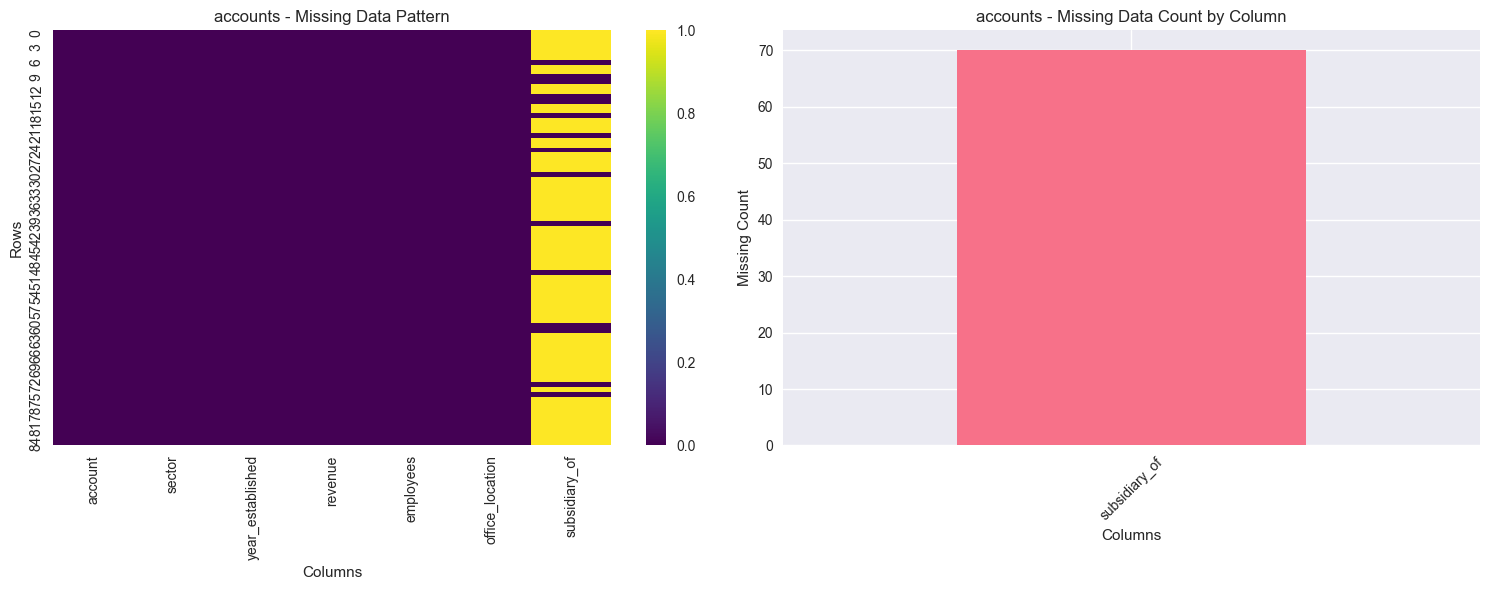


Analyzing missing patterns in PRODUCTS:
  No missing data detected

Analyzing missing patterns in SALES_PIPELINE:
  Missing data by column:
    account: 1,425 (16.2%)
    engage_date: 500 (5.7%)
    close_date: 2,089 (23.7%)
    close_value: 2,089 (23.7%)
  Strong missing data correlations:
    account ↔ close_date: 0.788
    account ↔ close_value: 0.788
    close_date ↔ close_value: 1.000


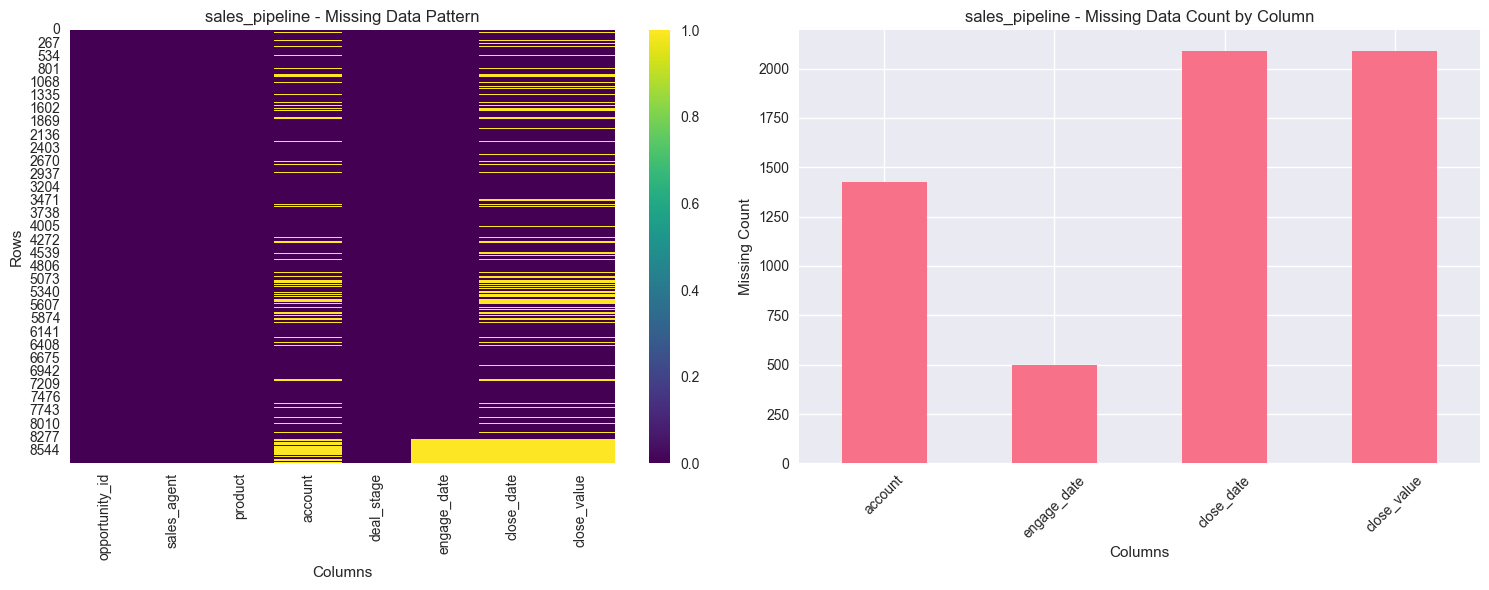


Analyzing missing patterns in SALES_TEAMS:
  No missing data detected

Analyzing missing patterns in DATA_DICTIONARY:
  No missing data detected


In [13]:
# Analyze missing data patterns
print("\nSTEP 3: MISSING DATA PATTERN ANALYSIS")
print("-" * 50)

missing_analyses = {}

for table_name, df in tables.items():
    print(f"\nAnalyzing missing patterns in {table_name.upper()}:")
    
    # Missing data analysis
    missing_analysis = analyze_missing_patterns(df, table_name)
    missing_analyses[table_name] = missing_analysis
    
    if missing_analysis['missing_summary']:
        print("  Missing data by column:")
        for item in missing_analysis['missing_summary']:
            print(f"    {item['column']}: {item['missing_count']:,} ({item['missing_percentage']:.1f}%)")
        
        # Analyze missing data correlations
        if missing_analysis['missing_correlation'] is not None:
            corr_matrix = missing_analysis['missing_correlation']
            
            # Find high correlations between missing patterns
            high_correlations = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    corr_val = corr_matrix.iloc[i, j]
                    if abs(corr_val) > 0.5:  # Strong correlation threshold
                        high_correlations.append((
                            corr_matrix.columns[i],
                            corr_matrix.columns[j], 
                            corr_val
                        ))
            
            if high_correlations:
                print("  Strong missing data correlations:")
                for col1, col2, corr in high_correlations:
                    print(f"    {col1} ↔ {col2}: {corr:.3f}")
        
        # Create missing data visualizations
        visualize_missing_patterns(df, table_name)
    
    else:
        print("  No missing data detected")


#### Step 4: Apply imputations

In [14]:
# Apply intelligent imputation
print("\nSTEP 4: INTELLIGENT MISSING DATA IMPUTATION")
print("-" * 50)

imputation_log = {}

for table_name, df in tables.items():
    print(f"\nApplying imputation strategies to {table_name.upper()}:")
    
    df_imputed = df.copy()
    table_imputation_log = []
    
    # Get missing data analysis for this table
    missing_info = missing_analyses.get(table_name, {})
    missing_summary = missing_info.get('missing_summary', [])
    
    if not missing_summary:
        print("  No missing data to impute")
        continue
    
    for missing_item in missing_summary:
        column = missing_item['column']
        missing_count = missing_item['missing_count']
        data_type = missing_item['data_type']
        
        print(f"\n  Processing {column} ({missing_count:,} missing values):")
        
        original_missing = df_imputed[column].isnull().sum()
        
        # Choose imputation strategy based on data type and business context
        if table_name == 'accounts':
            if column == 'subsidiary_of':
                # Logic: Most companies are independent
                df_imputed[column] = categorical_imputation(
                    df_imputed[column], strategy='custom', custom_value='Independent'
                )
                strategy_used = "Business logic: Independent companies"
            
            elif column in ['revenue', 'employees'] and 'sector' in df_imputed.columns:
                # Group-based numerical imputation
                df_imputed[column] = numerical_imputation(
                    df_imputed[column], strategy='group_median', 
                    group_by='sector', group_data=df_imputed
                )
                strategy_used = "Sector-based median imputation"
            
            else:
                # Default numerical or categorical imputation
                if pd.api.types.is_numeric_dtype(df_imputed[column]):
                    df_imputed[column] = numerical_imputation(
                        df_imputed[column], strategy='median'
                    )
                    strategy_used = "Median imputation"
                else:
                    df_imputed[column] = categorical_imputation(
                        df_imputed[column], strategy='mode'
                    )
                    strategy_used = "Mode imputation"
        
        elif table_name == 'sales_pipeline':
            if column == 'close_value' and 'deal_stage' in df_imputed.columns:
                # Business logic: Only Won deals should have close values
                won_median = df_imputed[df_imputed['deal_stage'] == 'Won']['close_value'].median()
                
                won_missing_mask = ((df_imputed['deal_stage'] == 'Won') & 
                                  df_imputed['close_value'].isnull())
                
                if won_missing_mask.any():
                    df_imputed.loc[won_missing_mask, 'close_value'] = won_median
                    strategy_used = f"Won deals imputed with median: ${won_median:,.0f}"
                else:
                    # impute Engaging deals with Won median
                    engaging_missing_mask = ((df_imputed['deal_stage'] == 'Engaging') & 
                                           df_imputed['close_value'].isnull())
                    if engaging_missing_mask.any():
                        df_imputed.loc[engaging_missing_mask, 'close_value'] = won_median
                        strategy_used = f"Engaging deals estimated with Won median: ${won_median:,.0f}"
                    else:
                        strategy_used = "No Won deals missing close_value"
            
            elif column in ['engage_date', 'close_date']:
                # Time series imputation using interpolation
                df_imputed[column] = pd.to_datetime(df_imputed[column], errors='coerce')
                df_imputed[column] = numerical_imputation(
                    df_imputed[column], strategy='interpolate'
                )
                strategy_used = "Temporal interpolation"
            
            elif column == 'account':
                # Use most frequent account for missing values
                df_imputed[column] = categorical_imputation(
                    df_imputed[column], strategy='mode'
                )
                strategy_used = "Most frequent account"
            
            else:
                # Default strategy based on data type
                if pd.api.types.is_numeric_dtype(df_imputed[column]):
                    df_imputed[column] = numerical_imputation(
                        df_imputed[column], strategy='median'
                    )
                    strategy_used = "Median imputation"
                else:
                    df_imputed[column] = categorical_imputation(
                        df_imputed[column], strategy='mode'
                    )
                    strategy_used = "Mode imputation"
        
        else:
            # Generic imputation for other tables
            if pd.api.types.is_numeric_dtype(df_imputed[column]):
                df_imputed[column] = numerical_imputation(
                    df_imputed[column], strategy='median'
                )
                strategy_used = "Median imputation"
            else:
                df_imputed[column] = categorical_imputation(
                    df_imputed[column], strategy='mode'
                )
                strategy_used = "Mode imputation"
        
        # Record imputation results
        final_missing = df_imputed[column].isnull().sum()
        values_imputed = original_missing - final_missing
        
        print(f"    Strategy: {strategy_used}")
        print(f"    Values imputed: {values_imputed:,}")
        print(f"    Remaining missing: {final_missing:,}")
        
        table_imputation_log.append({
            'column': column,
            'original_missing': original_missing,
            'values_imputed': values_imputed,
            'final_missing': final_missing,
            'strategy': strategy_used
        })
    
    tables[table_name] = df_imputed
    imputation_log[table_name] = table_imputation_log



STEP 4: INTELLIGENT MISSING DATA IMPUTATION
--------------------------------------------------

Applying imputation strategies to ACCOUNTS:

  Processing subsidiary_of (70 missing values):
    Strategy: Business logic: Independent companies
    Values imputed: 70
    Remaining missing: 0

Applying imputation strategies to PRODUCTS:
  No missing data to impute

Applying imputation strategies to SALES_PIPELINE:

  Processing account (1,425 missing values):
    Strategy: Most frequent account
    Values imputed: 1,425
    Remaining missing: 0

  Processing engage_date (500 missing values):
    Strategy: Temporal interpolation
    Values imputed: 500
    Remaining missing: 0

  Processing close_date (2,089 missing values):
    Strategy: Temporal interpolation
    Values imputed: 2,089
    Remaining missing: 0

  Processing close_value (2,089 missing values):
    Strategy: Engaging deals estimated with Won median: $1,117
    Values imputed: 1,589
    Remaining missing: 500

Applying imputa

#### Step 5: Detect and analyze outliers 


STEP 5: COMPREHENSIVE OUTLIER DETECTION
--------------------------------------------------

Outlier analysis for ACCOUNTS:

  Analyzing outliers in year_established:
    IQR: 0 outliers (0.0%)
    Z-Score: 0 outliers (0.0%)
    Modified Z-Score: 0 outliers (0.0%)
    Business context analysis:
      → Normal outlier rate


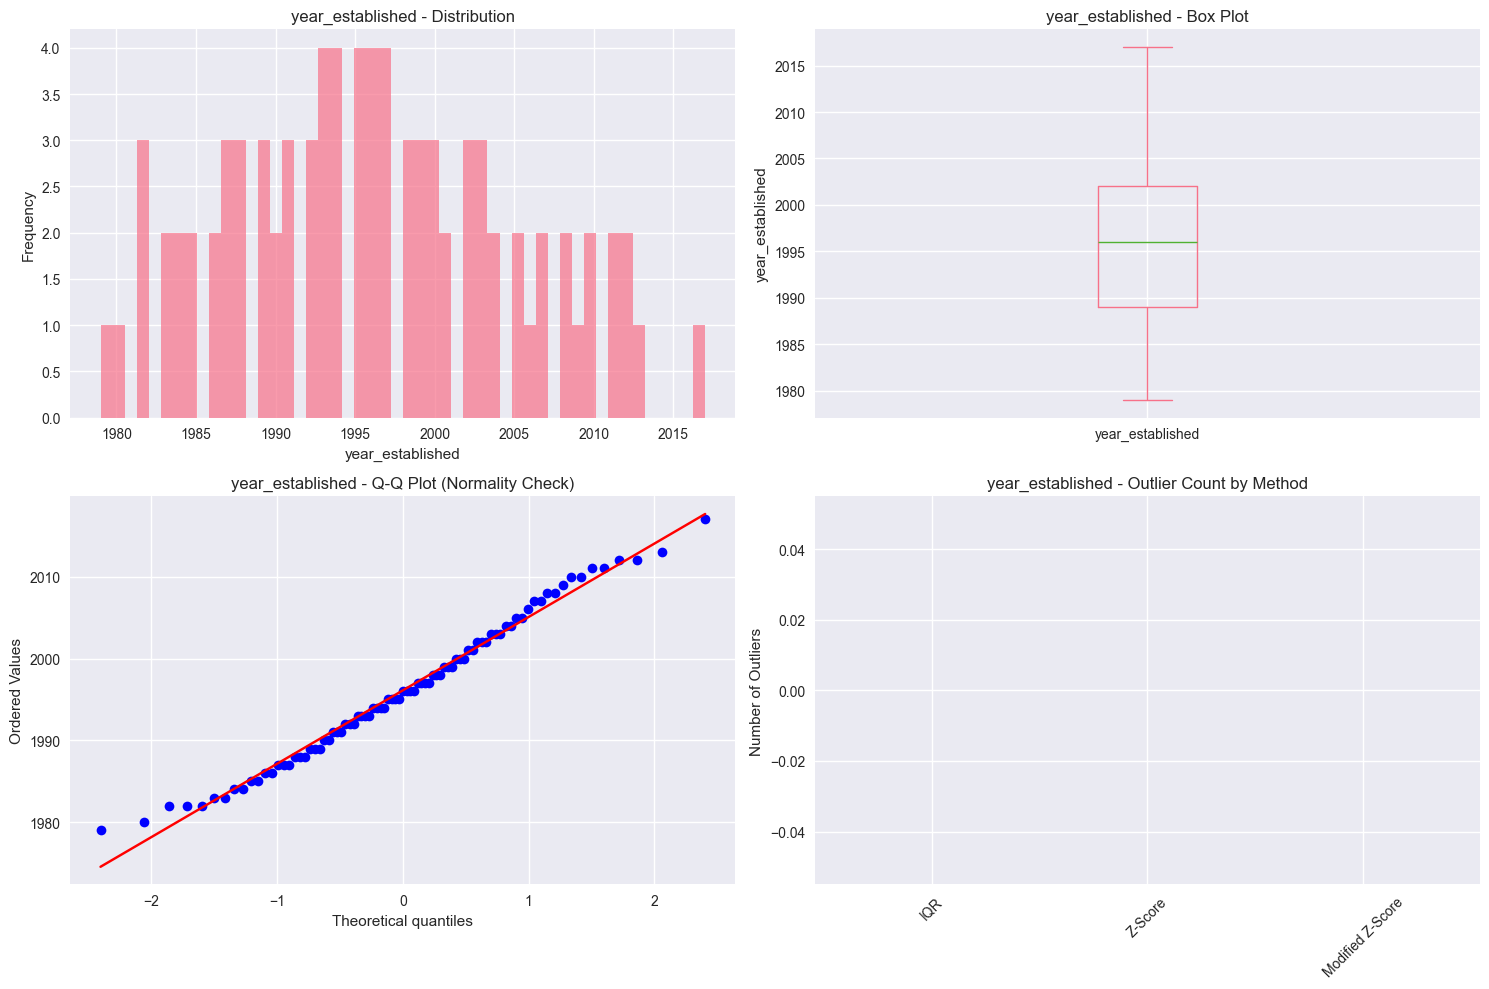


  Analyzing outliers in revenue:
    IQR: 6 outliers (7.1%)
    Z-Score: 1 outliers (1.2%)
    Modified Z-Score: 6 outliers (7.1%)
    Business context analysis:
      → Large revenue outliers expected (Fortune 500 companies)


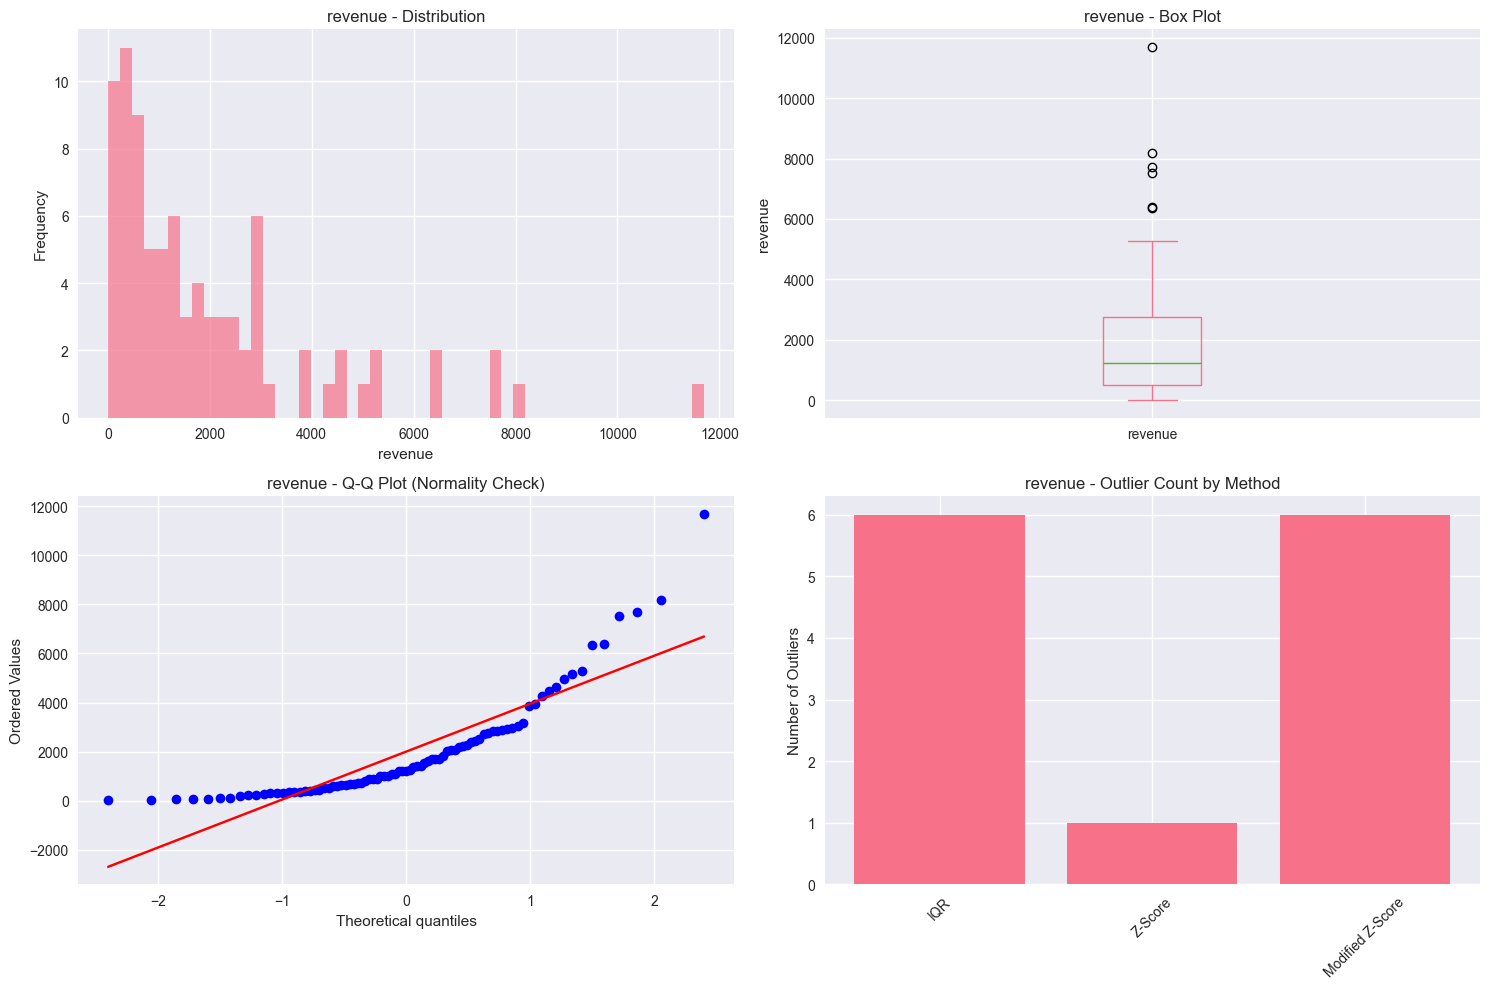


  Analyzing outliers in employees:
    IQR: 8 outliers (9.4%)
    Z-Score: 1 outliers (1.2%)
    Modified Z-Score: 8 outliers (9.4%)
    Business context analysis:
      → High outlier rate (9.4%) may indicate data quality issues


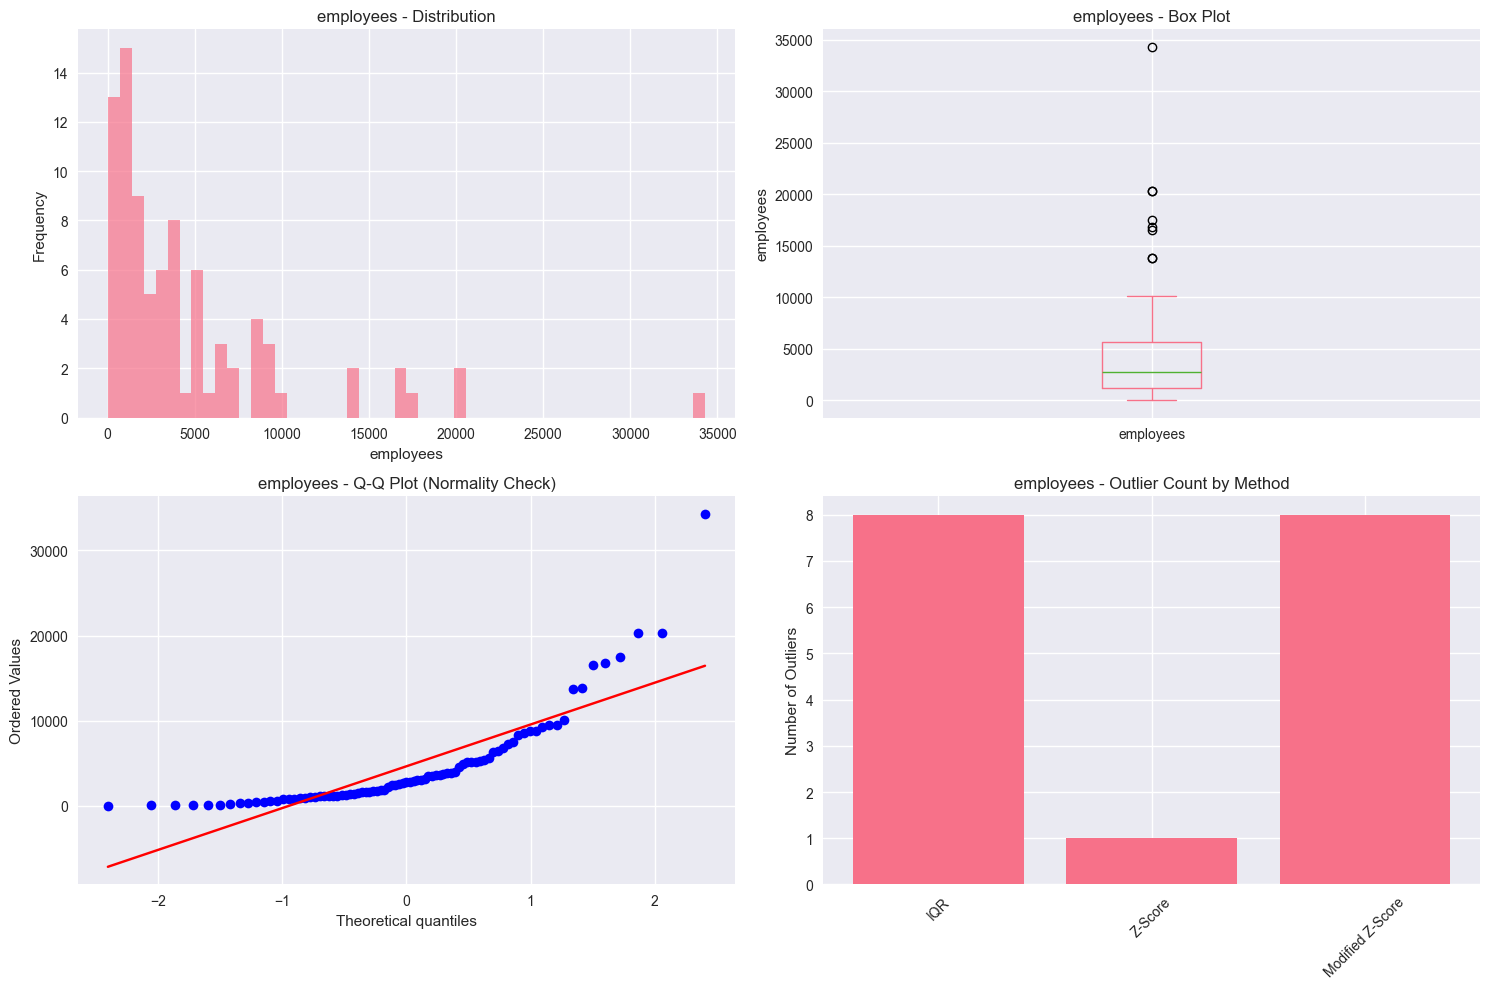


Outlier analysis for PRODUCTS:

Outlier analysis for SALES_PIPELINE:

  Analyzing outliers in close_value:
    IQR: 1844 outliers (22.2%)
    Z-Score: 15 outliers (0.2%)
    Modified Z-Score: 0 outliers (0.0%)
    Business context analysis:
      → High-value deals may be legitimate enterprise sales


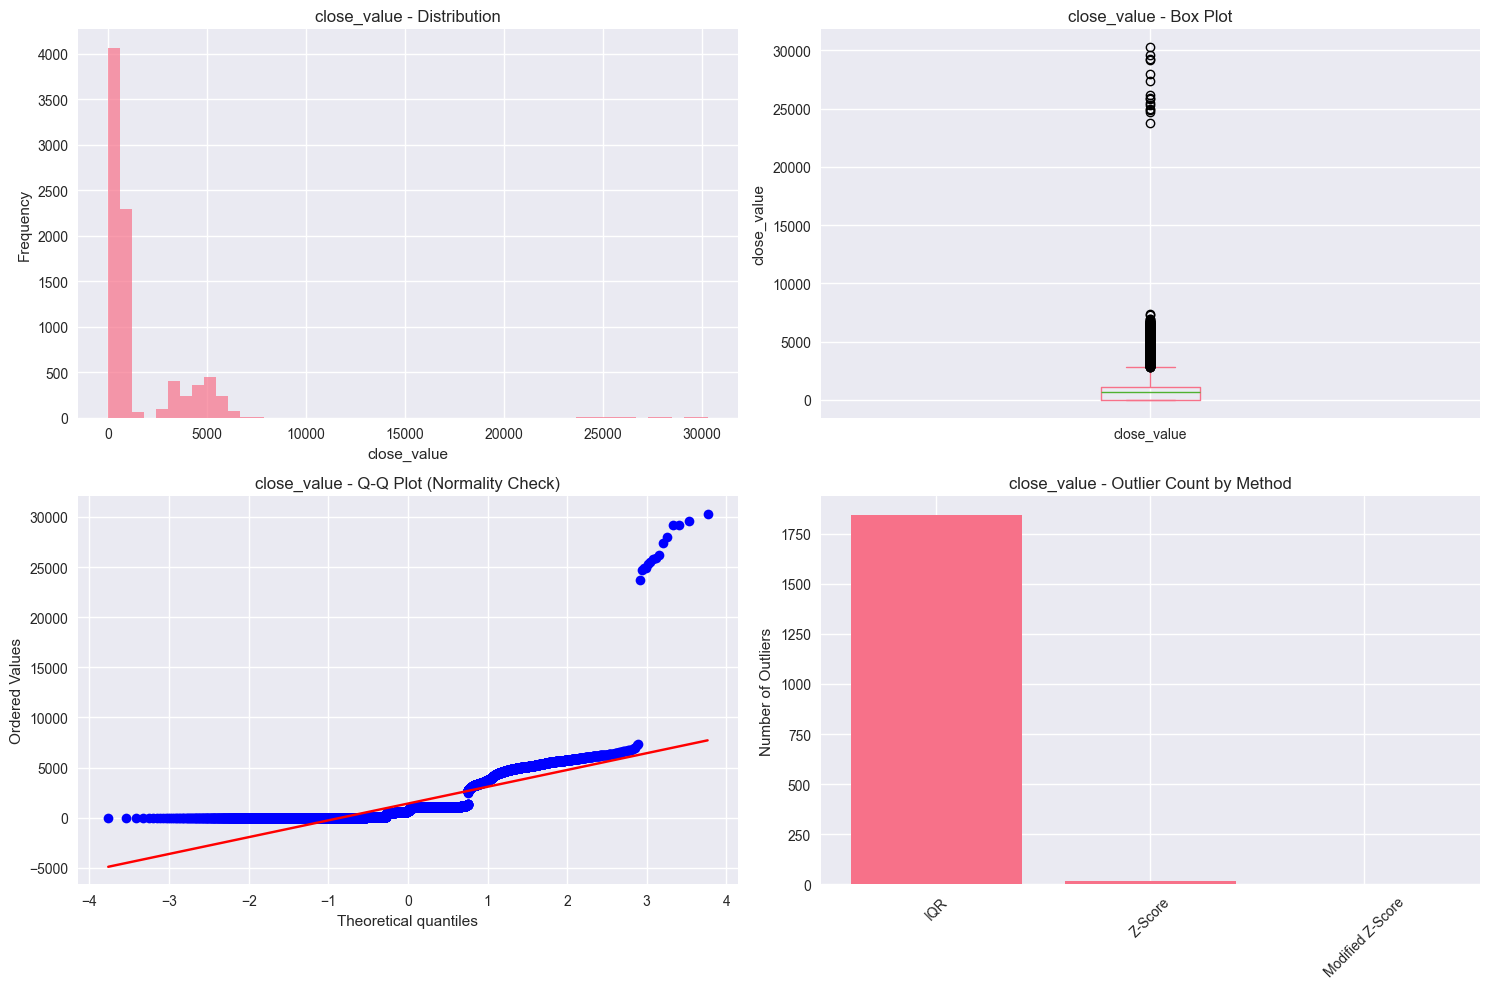


Outlier analysis for SALES_TEAMS:
  No numerical columns for outlier analysis

Outlier analysis for DATA_DICTIONARY:
  No numerical columns for outlier analysis


In [15]:
# Detect and analyze outliers
print("\nSTEP 5: COMPREHENSIVE OUTLIER DETECTION")
print("-" * 50)

outlier_analyses = {}

for table_name, df in tables.items():
    print(f"\nOutlier analysis for {table_name.upper()}:")
    
    # Focus on numerical columns for outlier detection
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numerical_cols) == 0:
        print("  No numerical columns for outlier analysis")
        continue
    
    table_outlier_results = {}
    
    for column in numerical_cols:
        if df[column].notna().sum() < 10:  
            continue
        
        print(f"\n  Analyzing outliers in {column}:")
        
        # Apply multiple outlier detection methods
        methods_results = {}
        
        # IQR method 
        iqr_results = iqr_outlier_detection(df[column])
        methods_results['IQR'] = iqr_results
        
        # Z-score method 
        zscore_results = zscore_outlier_detection(df[column])
        methods_results['Z-Score'] = zscore_results
        
        # Modified Z-score 
        modified_zscore_results = modified_zscore_outlier_detection(df[column])
        methods_results['Modified Z-Score'] = modified_zscore_results
        
        # Report results for each method
        for method_name, results in methods_results.items():
            outlier_count = results['outlier_count']
            outlier_pct = (outlier_count / df[column].notna().sum()) * 100
            print(f"    {method_name}: {outlier_count} outliers ({outlier_pct:.1f}%)")
        
        # Business context analysis and recommendations
        print(f"    Business context analysis:")
        
        if table_name == 'accounts' and column == 'revenue':
            print("      → Large revenue outliers expected (Fortune 500 companies)")
            treatment_recommendation = "retain"
        
        elif table_name == 'accounts' and column == 'employees':
            outlier_pct = (iqr_results['outlier_count'] / df[column].notna().sum()) * 100
            if outlier_pct > 5:
                print(f"      → High outlier rate ({outlier_pct:.1f}%) may indicate data quality issues")
                treatment_recommendation = "investigate"
            else:
                print("      → Normal outlier rate for employee counts")
                treatment_recommendation = "retain"
        
        elif table_name == 'sales_pipeline' and column == 'close_value':
            print("      → High-value deals may be legitimate enterprise sales")
            treatment_recommendation = "review"
        
        else:
            # Generic recommendation based on outlier percentage
            outlier_pct = (iqr_results['outlier_count'] / df[column].notna().sum()) * 100
            if outlier_pct > 10:
                print("      → High outlier rate")
                treatment_recommendation = "investigate"
            elif outlier_pct > 5:
                print("      → Moderate outlier rate")
                treatment_recommendation = "review"
            else:
                print("      → Normal outlier rate")
                treatment_recommendation = "retain"
        
        # Create comprehensive visualizations
        visualize_outliers(df, column, methods_results)
        
        table_outlier_results[column] = {
            'methods_results': methods_results,
            'treatment_recommendation': treatment_recommendation
        }
    
    outlier_analyses[table_name] = table_outlier_results

#### Step 6: Data transformation

In [16]:
# Apply data transformations
print("\nSTEP 6: DATA TRANSFORMATION AND STANDARDIZATION")
print("-" * 50)

transformation_log = {}

# Define data type mappings based on business understanding
type_mappings = {
    'sales_pipeline': {
        'engage_date': 'datetime64',
        'close_date': 'datetime64',
        'close_value': 'float64'
    },
    'accounts': {
        'year_established': 'int64',
        'revenue': 'float64',
        'employees': 'int64'
    },
    'products': {
        'sales_price': 'float64'
    }
}

for table_name, df in tables.items():
    print(f"\nTransforming {table_name.upper()}:")
    
    # Standardize column names
    df_transformed, name_changes = standardize_column_names(df)
    
    if name_changes:
        print("  Column names standardized (lowercase, underscores)")
    else:
        print("  Column names already standardized")
    
    # Apply data type conversions
    table_type_mappings = type_mappings.get(table_name, {})
    if table_type_mappings:
        df_transformed, conversion_log = convert_data_types(
            df_transformed, table_type_mappings
        )
        
        print("  Data type conversions:")
        for column, log_entry in conversion_log.items():
            if log_entry['success']:
                print(f"    {column}: {log_entry['from']} → {log_entry['to']}")
            else:
                print(f"    {column}: Conversion failed - {log_entry['error']}")
    
    tables[table_name] = df_transformed
    transformation_log[table_name] = {
        'column_names_changed': name_changes,
        'type_conversions': conversion_log if table_type_mappings else {}
    }


STEP 6: DATA TRANSFORMATION AND STANDARDIZATION
--------------------------------------------------

Transforming ACCOUNTS:
  Column names already standardized
  Data type conversions:
    year_established: int64 → int64
    revenue: float64 → float64
    employees: int64 → int64

Transforming PRODUCTS:
  Column names already standardized
  Data type conversions:
    sales_price: int64 → int64

Transforming SALES_PIPELINE:
  Column names already standardized
  Data type conversions:
    engage_date: datetime64[ns] → datetime64[ns]
    close_date: datetime64[ns] → datetime64[ns]
    close_value: float64 → float64

Transforming SALES_TEAMS:
  Column names already standardized

Transforming DATA_DICTIONARY:
  Column names standardized (lowercase, underscores)


#### Step 7: Quality assessment


STEP 7: COMPREHENSIVE QUALITY ASSESSMENT
--------------------------------------------------

PROCESSING RESULTS SUMMARY:

Table           Original   Final      Improvement  Missing Before  Missing After  
-------------------------------------------------------------------------------------
accounts           88.2%    100.0%    +11.8%           70            0
products          100.0%    100.0%     +0.0%            0            0
sales_pipeline     91.3%     99.3%     +8.0%        6,103          500
sales_teams       100.0%    100.0%     +0.0%            0            0
data_dictionary   100.0%    100.0%     +0.0%            0            0
-------------------------------------------------------------------------------------
TOTAL IMPROVEMENT                                           5,673            0


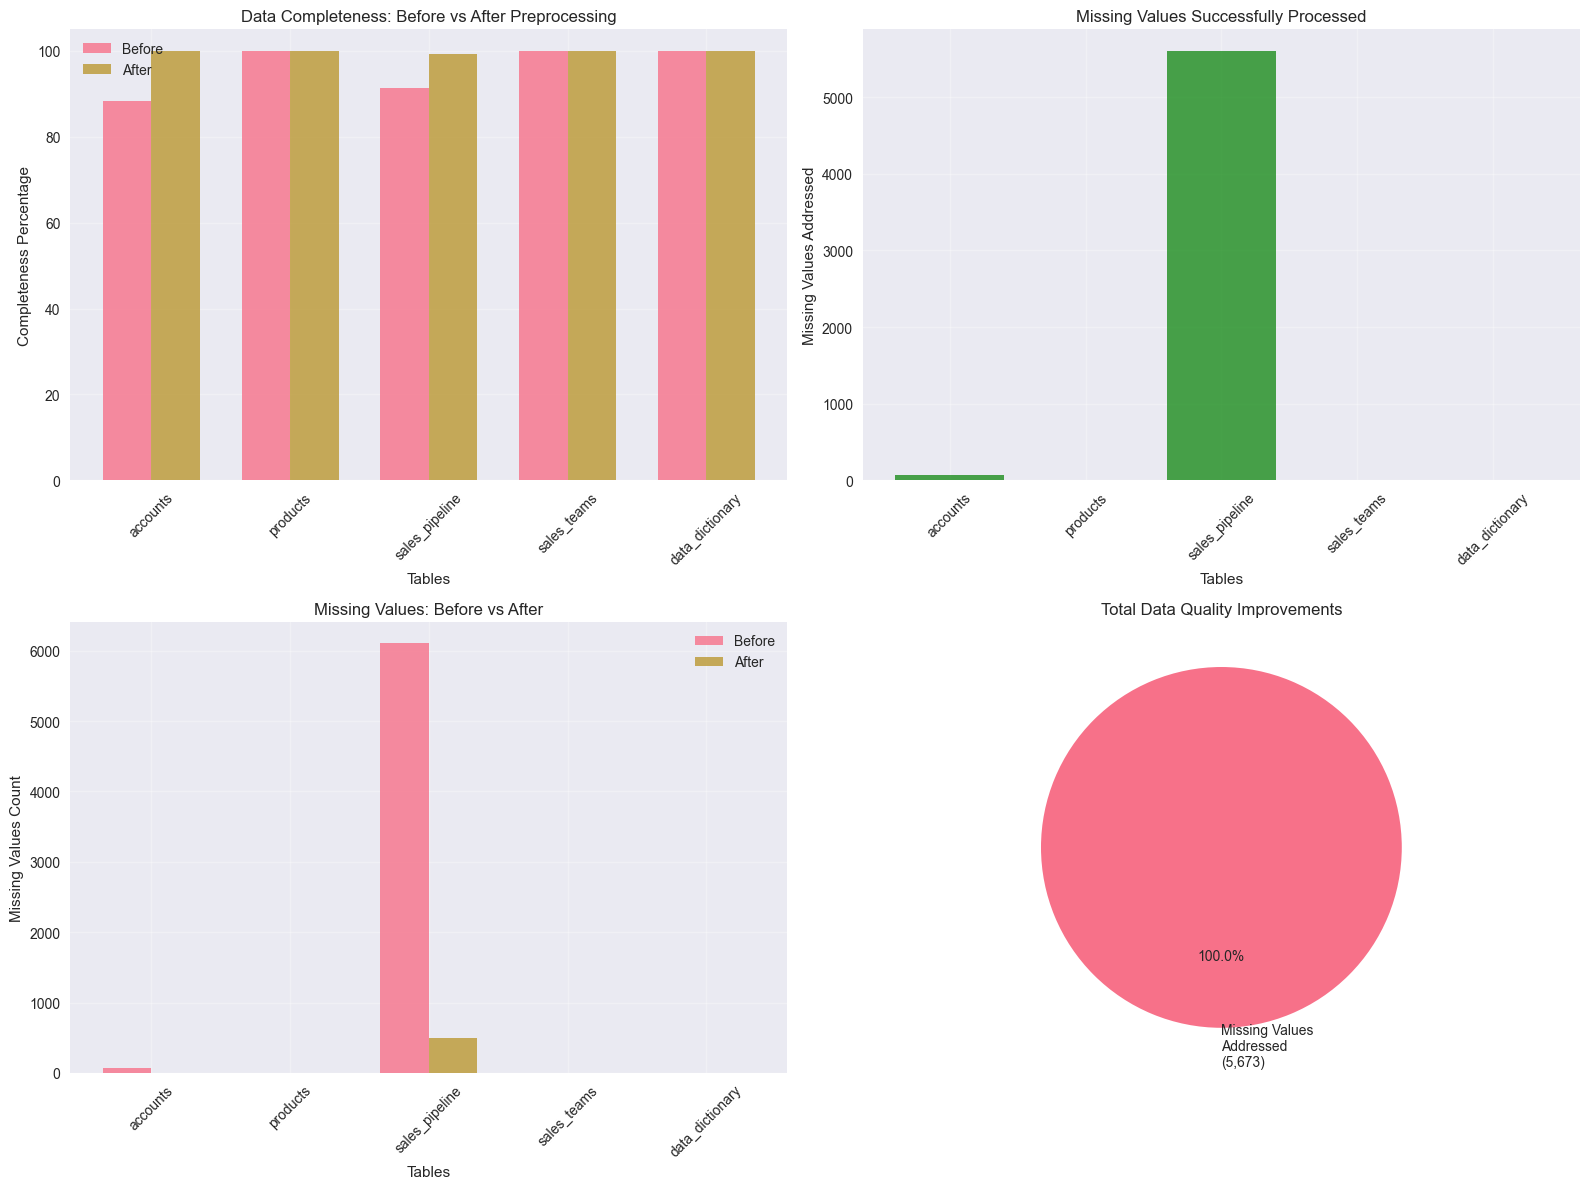

In [17]:
# Generate final quality report and visualization
print("\nSTEP 7: COMPREHENSIVE QUALITY ASSESSMENT")
print("-" * 50)

# Calculate final quality metrics
final_quality_metrics = []
for table_name, df in tables.items():
    final_metrics = assess_table_quality(df, table_name)
    final_quality_metrics.append(final_metrics)

# Compare initial and final metrics
print("\nPROCESSING RESULTS SUMMARY:")
print("=" * 40)

print(f"\n{'Table':<15} {'Original':<10} {'Final':<10} {'Improvement':<12} {'Missing Before':<15} {'Missing After':<15}")
print("-" * 85)

total_missing_improvement = 0
total_duplicates_removed = 0

for initial, final in zip(initial_quality_metrics, final_quality_metrics):
    table_name = initial['table_name']
    
    missing_improvement = initial['missing_cells'] - final['missing_cells']
    duplicate_improvement = initial['duplicate_rows'] - final['duplicate_rows']
    
    completeness_improvement = final['completeness_pct'] - initial['completeness_pct']
    
    print(f"{table_name:<15} {initial['completeness_pct']:>7.1f}% {final['completeness_pct']:>8.1f}% {completeness_improvement:>+8.1f}% {initial['missing_cells']:>12,} {final['missing_cells']:>12,}")
    
    total_missing_improvement += missing_improvement
    total_duplicates_removed += duplicate_improvement

print("-" * 85)
print(f"{'TOTAL IMPROVEMENT':<15} {'':<10} {'':<10} {'':<12} {total_missing_improvement:>12,} {total_duplicates_removed:>12,}")

# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extract data for visualization
table_names = [metrics['table_name'] for metrics in initial_quality_metrics]
completeness_before = [metrics['completeness_pct'] for metrics in initial_quality_metrics]
completeness_after = [metrics['completeness_pct'] for metrics in final_quality_metrics]
missing_before = [metrics['missing_cells'] for metrics in initial_quality_metrics]
missing_after = [metrics['missing_cells'] for metrics in final_quality_metrics]

# Completeness improvement comparison
x = np.arange(len(table_names))
width = 0.35

axes[0,0].bar(x - width/2, completeness_before, width, label='Before', alpha=0.8)
axes[0,0].bar(x + width/2, completeness_after, width, label='After', alpha=0.8)
axes[0,0].set_xlabel('Tables')
axes[0,0].set_ylabel('Completeness Percentage')
axes[0,0].set_title('Data Completeness: Before vs After Preprocessing')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(table_names, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Missing values comparison
missing_reduced = [before - after for before, after in zip(missing_before, missing_after)]
axes[0,1].bar(table_names, missing_reduced, color='green', alpha=0.7)
axes[0,1].set_xlabel('Tables')
axes[0,1].set_ylabel('Missing Values Addressed')
axes[0,1].set_title('Missing Values Successfully Processed')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Before and after missing values
axes[1,0].bar(x - width/2, missing_before, width, label='Before', alpha=0.8)
axes[1,0].bar(x + width/2, missing_after, width, label='After', alpha=0.8)
axes[1,0].set_xlabel('Tables')
axes[1,0].set_ylabel('Missing Values Count')
axes[1,0].set_title('Missing Values: Before vs After')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(table_names, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Overall improvement summary
if total_missing_improvement > 0:
    axes[1,1].pie([total_missing_improvement], labels=[f'Missing Values\nAddressed\n({total_missing_improvement:,})'], 
                  autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Total Data Quality Improvements')
else:
    axes[1,1].text(0.5, 0.5, 'Data Quality\nAlready High', 
                  horizontalalignment='center', verticalalignment='center',
                  transform=axes[1,1].transAxes, fontsize=14)
    axes[1,1].set_title('Data Quality Status')

plt.tight_layout()
plt.show()

#### Step 8: Save preprocessed data

In [18]:
# Save processed tables
print("\nSTEP 8: SAVING PREPROCESSED DATA")
print("-" * 50)

output_path = Path('data/interim/')
output_path.mkdir(parents=True, exist_ok=True)

print(f"Saving preprocessed tables to {output_path}:")
for table_name, df in tables.items():
    output_file = output_path / f"{table_name}_preprocessed.csv"
    df.to_csv(output_file, index=False)
    print(f"  Saved {table_name}_preprocessed.csv ({df.shape[0]:,} rows × {df.shape[1]} columns)")

print(f"\n" + "=" * 60)
print("COMPREHENSIVE PREPROCESSING PIPELINE COMPLETED")
print("=" * 60)
print(f"Total missing values addressed: {total_missing_improvement:,}")
print(f"Total duplicate rows removed: {total_duplicates_removed:,}")
print(f"Processed tables saved to: {output_path}")


STEP 8: SAVING PREPROCESSED DATA
--------------------------------------------------
Saving preprocessed tables to data/interim:
  Saved accounts_preprocessed.csv (85 rows × 7 columns)
  Saved products_preprocessed.csv (7 rows × 3 columns)
  Saved sales_pipeline_preprocessed.csv (8,800 rows × 8 columns)
  Saved sales_teams_preprocessed.csv (35 rows × 3 columns)
  Saved data_dictionary_preprocessed.csv (21 rows × 3 columns)

COMPREHENSIVE PREPROCESSING PIPELINE COMPLETED
Total missing values addressed: 5,673
Total duplicate rows removed: 0
Processed tables saved to: data/interim


---

# PART 3: DATA INTEGRATION

**Business Context:** Multi-table CRM database integration  
**Objective:** Merge preprocessed tables into analysis-ready master dataset  
**Expected Outcome:** Clean integrated dataset ready for EDA and analysis

---

#### Step 2: Load preprocessing tables

In [19]:
print("\nSTEP 2: LOADING PREPROCESSED TABLES")
print("-" * 50)

# Load all preprocessed tables
data_path = Path('data/interim/')
tables = {}

table_files = {
    'accounts': 'accounts_preprocessed.csv',
    'products': 'products_preprocessed.csv', 
    'sales_pipeline': 'sales_pipeline_preprocessed.csv',
    'sales_teams': 'sales_teams_preprocessed.csv',
    'data_dictionary': 'data_dictionary_preprocessed.csv'
}

for table_name, filename in table_files.items():
    file_path = data_path / filename
    try:
        df = pd.read_csv(file_path)
        tables[table_name] = df
        print(f"Loaded {table_name}: {df.shape[0]:,} rows X {df.shape[1]} columns")
        
        # Convert datetime columns back to datetime 
        if table_name == 'sales_pipeline':
            df['engage_date'] = pd.to_datetime(df['engage_date'])
            df['close_date'] = pd.to_datetime(df['close_date'])
            
    except FileNotFoundError:
        print(f"Error: {filename} not found")
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")

print(f"\nSuccessfully loaded {len(tables)} tables for integration")



STEP 2: LOADING PREPROCESSED TABLES
--------------------------------------------------
Loaded accounts: 85 rows X 7 columns
Loaded products: 7 rows X 3 columns
Loaded sales_pipeline: 8,800 rows X 8 columns
Loaded sales_teams: 35 rows X 3 columns
Loaded data_dictionary: 21 rows X 3 columns

Successfully loaded 5 tables for integration


#### Step 3: Examine table structures and their relationships

In [20]:
print("\nSTEP 3: TABLE STRUCTURE ANALYSIS")
print("-" * 50)

for table_name, df in tables.items():
    print(f"\n{table_name.upper()}:")
    print(f"Shape: {df.shape[0]:,} rows X {df.shape[1]} columns")
    print(f"Columns: {list(df.columns)}")
    
    # Show key columns for relationship identification
    if table_name == 'sales_pipeline':
        print(f"  Key relationships: account, product, sales_agent")
    elif table_name == 'accounts':
        print(f"  Primary key: account")
    elif table_name == 'products':
        print(f"  Primary key: product")
    elif table_name == 'sales_teams':
        print(f"  Primary key: sales_agent")



STEP 3: TABLE STRUCTURE ANALYSIS
--------------------------------------------------

ACCOUNTS:
Shape: 85 rows X 7 columns
Columns: ['account', 'sector', 'year_established', 'revenue', 'employees', 'office_location', 'subsidiary_of']
  Primary key: account

PRODUCTS:
Shape: 7 rows X 3 columns
Columns: ['product', 'series', 'sales_price']
  Primary key: product

SALES_PIPELINE:
Shape: 8,800 rows X 8 columns
Columns: ['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage', 'engage_date', 'close_date', 'close_value']
  Key relationships: account, product, sales_agent

SALES_TEAMS:
Shape: 35 rows X 3 columns
Columns: ['sales_agent', 'manager', 'regional_office']
  Primary key: sales_agent

DATA_DICTIONARY:
Shape: 21 rows X 3 columns
Columns: ['table', 'field', 'description']


#### Step 4: Validate foreign key relationships

In [21]:
print("\nSTEP 4: RELATIONSHIP VALIDATION")
print("-" * 50)

def validate_foreign_keys(primary_table, foreign_table, primary_key, foreign_key, relationship_name):
    """Validate foreign key relationships between tables"""
    
    # Get unique values from both tables
    primary_values = set(primary_table[primary_key].dropna())
    foreign_values = set(foreign_table[foreign_key].dropna())
    
    # Calculate match statistics
    total_foreign = len(foreign_values)
    matched = len(foreign_values.intersection(primary_values))
    unmatched = len(foreign_values - primary_values)
    match_rate = (matched / total_foreign * 100) if total_foreign > 0 else 0
    
    print(f"\n{relationship_name}:")
    print(f"Foreign key values: {total_foreign:,}")
    print(f"Matched: {matched:,} ({match_rate:.1f}%)")
    print(f"Unmatched: {unmatched:,}")
    
    if unmatched > 0:
        unmatched_values = list(foreign_values - primary_values)[:5]  # Show first 5
        print(f"  Sample unmatched: {unmatched_values}")
    
    return {
        'relationship': relationship_name,
        'total_foreign': total_foreign,
        'matched': matched,
        'unmatched': unmatched,
        'match_rate': match_rate
    }

# Validate all key relationships
validation_results = []

# sales_pipeline → accounts
result1 = validate_foreign_keys(
    tables['accounts'], tables['sales_pipeline'], 
    'account', 'account', 
    "Sales Pipeline → Accounts"
)
validation_results.append(result1)

# sales_pipeline → products  
result2 = validate_foreign_keys(
    tables['products'], tables['sales_pipeline'],
    'product', 'product',
    "Sales Pipeline → Products"
)
validation_results.append(result2)

# sales_pipeline → sales_teams
result3 = validate_foreign_keys(
    tables['sales_teams'], tables['sales_pipeline'],
    'sales_agent', 'sales_agent', 
    "Sales Pipeline → Sales Teams"
)
validation_results.append(result3)



STEP 4: RELATIONSHIP VALIDATION
--------------------------------------------------

Sales Pipeline → Accounts:
Foreign key values: 85
Matched: 85 (100.0%)
Unmatched: 0

Sales Pipeline → Products:
Foreign key values: 7
Matched: 6 (85.7%)
Unmatched: 1
  Sample unmatched: ['GTXPro']

Sales Pipeline → Sales Teams:
Foreign key values: 30
Matched: 30 (100.0%)
Unmatched: 0


#### Step 5: Create integrated master dataset

In [22]:
print("\nSTEP 5: MASTER DATASET INTEGRATION")
print("-" * 50)

# Start with sales_pipeline as the primary table (contains all opportunities)
master_df = tables['sales_pipeline'].copy()
print(f"Starting with sales_pipeline: {master_df.shape[0]:,} rows")

# Left join with accounts (company information)
print("Joining with accounts table...")
master_df = master_df.merge(
    tables['accounts'], 
    on='account', 
    how='left', 
    suffixes=('', '_account')
)
print(f"After joining accounts: {master_df.shape[0]:,} rows × {master_df.shape[1]} columns")

# Left join with products (product details and pricing)
print("Joining with products table...")
master_df = master_df.merge(
    tables['products'],
    on='product',
    how='left',
    suffixes=('', '_product')
)
print(f"After joining products: {master_df.shape[0]:,} rows × {master_df.shape[1]} columns")

# Left join with sales_teams (sales agent details)
print("Joining with sales_teams table...")
master_df = master_df.merge(
    tables['sales_teams'],
    on='sales_agent', 
    how='left',
    suffixes=('', '_team')
)
print(f"After joining sales_teams: {master_df.shape[0]:,} rows × {master_df.shape[1]} columns")

print(f"\nFinal integrated dataset: {master_df.shape[0]:,} rows × {master_df.shape[1]} columns")



STEP 5: MASTER DATASET INTEGRATION
--------------------------------------------------
Starting with sales_pipeline: 8,800 rows
Joining with accounts table...
After joining accounts: 8,800 rows × 14 columns
Joining with products table...
After joining products: 8,800 rows × 16 columns
Joining with sales_teams table...
After joining sales_teams: 8,800 rows × 18 columns

Final integrated dataset: 8,800 rows × 18 columns


#### Step 6: Data quality assessment for integrated dataset

In [23]:
print("\nSTEP 6: INTEGRATED DATASET QUALITY ASSESSMENT")
print("-" * 50)

# Missing value analysis
missing_summary = master_df.isnull().sum()
missing_pct = (missing_summary / len(master_df) * 100).round(1)

print("Missing values in integrated dataset:")
missing_df = pd.DataFrame({
    'Column': missing_summary.index,
    'Missing_Count': missing_summary.values,
    'Missing_Pct': missing_pct.values
}).query('Missing_Count > 0').sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    for _, row in missing_df.head(10).iterrows():
        print(f"{row['Column']}: {row['Missing_Count']:,} ({row['Missing_Pct']:.1f}%)")
else:
    print("  No missing values detected!")

# Data completeness by key business dimensions
print(f"\nData completeness analysis:")
print(f"Total opportunities: {len(master_df):,}")

# Check coverage from each joined table
if 'revenue' in master_df.columns:
    account_coverage = master_df['revenue'].notna().sum()
    print(f"Opportunities with account data: {account_coverage:,} ({account_coverage/len(master_df)*100:.1f}%)")

if 'sales_price' in master_df.columns:
    product_coverage = master_df['sales_price'].notna().sum()
    print(f"Opportunities with product data: {product_coverage:,} ({product_coverage/len(master_df)*100:.1f}%)")

if 'manager' in master_df.columns:
    team_coverage = master_df['manager'].notna().sum()
    print(f"Opportunities with sales team data: {team_coverage:,} ({team_coverage/len(master_df)*100:.1f}%)")



STEP 6: INTEGRATED DATASET QUALITY ASSESSMENT
--------------------------------------------------
Missing values in integrated dataset:
series: 1,480 (16.8%)
sales_price: 1,480 (16.8%)
close_value: 500 (5.7%)

Data completeness analysis:
Total opportunities: 8,800
Opportunities with account data: 8,800 (100.0%)
Opportunities with product data: 7,320 (83.2%)
Opportunities with sales team data: 8,800 (100.0%)


#### Step 7: Integration validation

In [24]:
print("\nSTEP 7: INTEGRATION VALIDATION")
print("-" * 50)

# Validate data integrity
print("Data integrity checks:")

# Check for unexpected duplicates
duplicate_opps = master_df['opportunity_id'].duplicated().sum()
print(f"Duplicate opportunities: {duplicate_opps} (should be 0)")

# Check join effectiveness  
total_ops = len(master_df)

if 'revenue' in master_df.columns:
    account_join_success = (master_df['revenue'].notna().sum() / total_ops * 100)
    print(f"Account data joined: {account_join_success:.1f}% of opportunities")

if 'sales_price' in master_df.columns:
    product_join_success = (master_df['sales_price'].notna().sum() / total_ops * 100) 
    print(f"Product data joined: {product_join_success:.1f}% of opportunities")

if 'manager' in master_df.columns:
    team_join_success = (master_df['manager'].notna().sum() / total_ops * 100)
    print(f"Team data joined: {team_join_success:.1f}% of opportunities")

# Business logic validation
if 'deal_stage' in master_df.columns and 'close_value' in master_df.columns:
    won_deals_with_value = master_df[
        (master_df['deal_stage'] == 'Won') & 
        (master_df['close_value'].notna())
    ].shape[0]
    total_won_deals = (master_df['deal_stage'] == 'Won').sum()
    
    if total_won_deals > 0:
        print(f"Won deals with values: {won_deals_with_value}/{total_won_deals} ({won_deals_with_value/total_won_deals*100:.1f}%)")



STEP 7: INTEGRATION VALIDATION
--------------------------------------------------
Data integrity checks:
Duplicate opportunities: 0 (should be 0)
Account data joined: 100.0% of opportunities
Product data joined: 83.2% of opportunities
Team data joined: 100.0% of opportunities
Won deals with values: 4238/4238 (100.0%)


#### Step 8: Display a sample of integrated data

In [25]:
print("\nSTEP 8: INTEGRATED DATASET PREVIEW")
print("-" * 50)

print("Sample of integrated data:")
print(master_df.head())

print(f"\nDataset info:")
print(f"Shape: {master_df.shape}")

print(f"\nColumn summary:")
for col in master_df.columns:
    non_null = master_df[col].notna().sum()
    data_type = master_df[col].dtype
    print(f"{col}: {non_null:,}/{len(master_df):,} non-null ({data_type})")



STEP 8: INTEGRATED DATASET PREVIEW
--------------------------------------------------
Sample of integrated data:
  opportunity_id      sales_agent         product  account deal_stage  \
0       1C1I7A6R      Moses Frase  GTX Plus Basic  Cancity        Won   
1       Z063OYW0  Darcel Schlecht          GTXPro    Isdom        Won   
2       EC4QE1BX  Darcel Schlecht      MG Special  Cancity        Won   
3       MV1LWRNH      Moses Frase       GTX Basic  Codehow        Won   
4       PE84CX4O        Zane Levy       GTX Basic   Hatfan        Won   

  engage_date close_date  close_value    sector  year_established  revenue  \
0  2016-10-20 2017-03-01       1054.0    retail              2001   718.62   
1  2016-10-25 2017-03-11       4514.0   medical              2002  3178.24   
2  2016-10-25 2017-03-07         50.0    retail              2001   718.62   
3  2016-10-25 2017-03-09        588.0  software              1998  2714.90   
4  2016-10-25 2017-03-02        517.0  services          

#### Step 9: Save the integrated dataset

In [26]:
print("\nSTEP 8: SAVING INTEGRATED DATASET")
print("-" * 50)

# Create processed data directory
output_path = Path('data/processed/')
output_path.mkdir(parents=True, exist_ok=True)

# Save master integrated dataset
master_filename = 'crm_master_dataset.csv'
master_filepath = output_path / master_filename
master_df.to_csv(master_filepath, index=False)
print(f"Saved {master_filename}: {master_df.shape[0]:,} rows X {master_df.shape[1]} columns")

# Save integration summary
integration_summary = {
    'metric': [
        'Total Opportunities',
        'Total Features',
        'Original Tables Integrated',
        'Account Data Coverage',
        'Product Data Coverage', 
        'Sales Team Data Coverage',
        'Complete Records'
    ],
    'value': [
        len(master_df),
        master_df.shape[1],
        len(tables) - 1,  
        master_df['revenue'].notna().sum() if 'revenue' in master_df.columns else 0,
        master_df['sales_price'].notna().sum() if 'sales_price' in master_df.columns else 0,
        master_df['manager'].notna().sum() if 'manager' in master_df.columns else 0,
        master_df.dropna().shape[0]
    ]
}

summary_df = pd.DataFrame(integration_summary)
summary_df.to_csv(output_path / 'integration_summary.csv', index=False)
print(f"Saved integration_summary.csv")

print(f"\n" + "=" * 60)
print("DATA INTEGRATION COMPLETED")
print("=" * 60)
print(f"Master dataset: {master_df.shape[0]:,} opportunities × {master_df.shape[1]} features")
print(f"Integration success rates:")
for result in validation_results:
    print(f"{result['relationship']}: {result['match_rate']:.1f}%")
print(f"Output location: {output_path}")
print("Ready for exploratory data analysis!")


STEP 8: SAVING INTEGRATED DATASET
--------------------------------------------------
Saved crm_master_dataset.csv: 8,800 rows X 18 columns
Saved integration_summary.csv

DATA INTEGRATION COMPLETED
Master dataset: 8,800 opportunities × 18 features
Integration success rates:
Sales Pipeline → Accounts: 100.0%
Sales Pipeline → Products: 85.7%
Sales Pipeline → Sales Teams: 100.0%
Output location: data/processed
Ready for exploratory data analysis!


---

# PART 4: EXPLORATORY DATA ANALYSIS (EDA)

**Business Context:** Comprehensive analysis of integrated CRM sales data  
**Objective:** Discover patterns, relationships, and insights in sales data  
**Expected Outcome:** Data-driven insights for business decision making

---

#### Step 2: Load the processed dataset (The combined one)

In [27]:
# Load the master dataset
df_ = pd.read_csv('data/processed/crm_master_dataset.csv')

# Convert datetime columns
df_['engage_date'] = pd.to_datetime(df_['engage_date'])
df_['close_date'] = pd.to_datetime(df_['close_date'])

print(f"Dataset loaded: {df_.shape[0]:,} rows × {df_.shape[1]} columns")


Dataset loaded: 8,800 rows × 18 columns


#### Step 3: Basic data exploration with dataframe 

In [28]:
df_.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,sector,year_established,revenue,employees,office_location,subsidiary_of,series,sales_price,manager,regional_office
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0,retail,2001,718.62,2448,United States,Independent,GTX,1096.0,Dustin Brinkmann,Central
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0,medical,2002,3178.24,4540,United States,Independent,NaN,NaN,Melvin Marxen,Central
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0,retail,2001,718.62,2448,United States,Independent,MG,55.0,Melvin Marxen,Central
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0,software,1998,2714.90,2641,United States,Acme Corporation,GTX,550.0,Dustin Brinkmann,Central
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0,services,1982,792.46,1299,United States,Independent,GTX,550.0,Summer Sewald,West


#### Step 4: Descriptive statistics for numerical featuress for better readability

In [29]:
# Convert close_value to thousands for better readability
df_['close_value_k'] = (df_['close_value']/1000).round(1)

df_.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
engage_date,8800,2017-06-25 11:22:12,2016-10-20 00:00:00,2017-04-07 00:00:00,2017-07-01 00:00:00,2017-09-10 00:00:00,2017-12-27 00:00:00,NaN
close_date,8800,2017-08-10 05:04:56.181818112,2017-03-01 00:00:00,2017-05-23 00:00:00,2017-08-10 00:00:00,2017-10-30 15:00:00,2017-12-31 00:00:00,NaN
close_value,8300.0,1419.330964,0.0,0.0,643.5,1136.0,30288.0,2091.88903
year_established,8800.0,1995.729205,1979.0,1990.0,1997.0,2000.0,2017.0,8.428892
revenue,8800.0,3390.990748,4.54,718.62,2173.98,6354.87,11698.03,3172.150363
employees,8800.0,7449.718636,9.0,1588.0,4540.0,13809.0,34288.0,7400.427254
sales_price,7320.0,1885.394126,55.0,550.0,1096.0,3393.0,26768.0,2619.399523
close_value_k,8300.0,1.418807,0.0,0.0,0.6,1.1,30.3,2.090896


#### Step 5: Sample dataset (random)

In [30]:
# Randomly sample for faster processing during EDA
df = df_.sample(frac=0.30, random_state=42) # Randomly sample 30% of the dataset
print(f"Working with sample: {df.shape[0]:,} rows for EDA")

Working with sample: 2,640 rows for EDA


#### Step 6: Data type and identifying features 

In [31]:
df.describe().transpose()


,count,mean,min,25%,50%,75%,max,std
engage_date,2640,2017-06-25 12:21:16.363636224,2016-10-20 00:00:00,2017-04-05 00:00:00,2017-07-03 00:00:00,2017-09-13 00:00:00,2017-12-27 00:00:00,NaN
close_date,2640,2017-08-10 08:23:00.233766400,2017-03-01 00:00:00,2017-05-22 00:00:00,2017-08-07 00:00:00,2017-11-03 00:00:00,2017-12-31 00:00:00,NaN
close_value,2476.0,1434.16357,0.0,0.0,880.5,1136.5,29617.0,2075.364537
year_established,2640.0,1995.806439,1979.0,1990.0,1997.0,2000.0,2017.0,8.492113
revenue,2640.0,3431.8395,4.54,718.62,2214.94,6395.05,11698.03,3179.045349
employees,2640.0,7487.542803,9.0,1501.0,4874.0,16499.0,34288.0,7308.875516
sales_price,2176.0,1922.386949,55.0,550.0,1096.0,3393.0,26768.0,2630.910632
close_value_k,2476.0,1.433239,0.0,0.0,0.9,1.1,29.6,2.074248


#### Step 7: Identify numerical and categorical columns 

In [32]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

print("Numerical columns:", numerical_columns.tolist()[:10])  # Show first 10
print("Categorical columns:", categorical_columns.tolist())

Numerical columns: ['close_value', 'year_established', 'revenue', 'employees', 'sales_price', 'close_value_k']
Categorical columns: ['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage', 'sector', 'office_location', 'subsidiary_of', 'series', 'manager', 'regional_office']


#### Step 8: Correlation analysis with a target variable

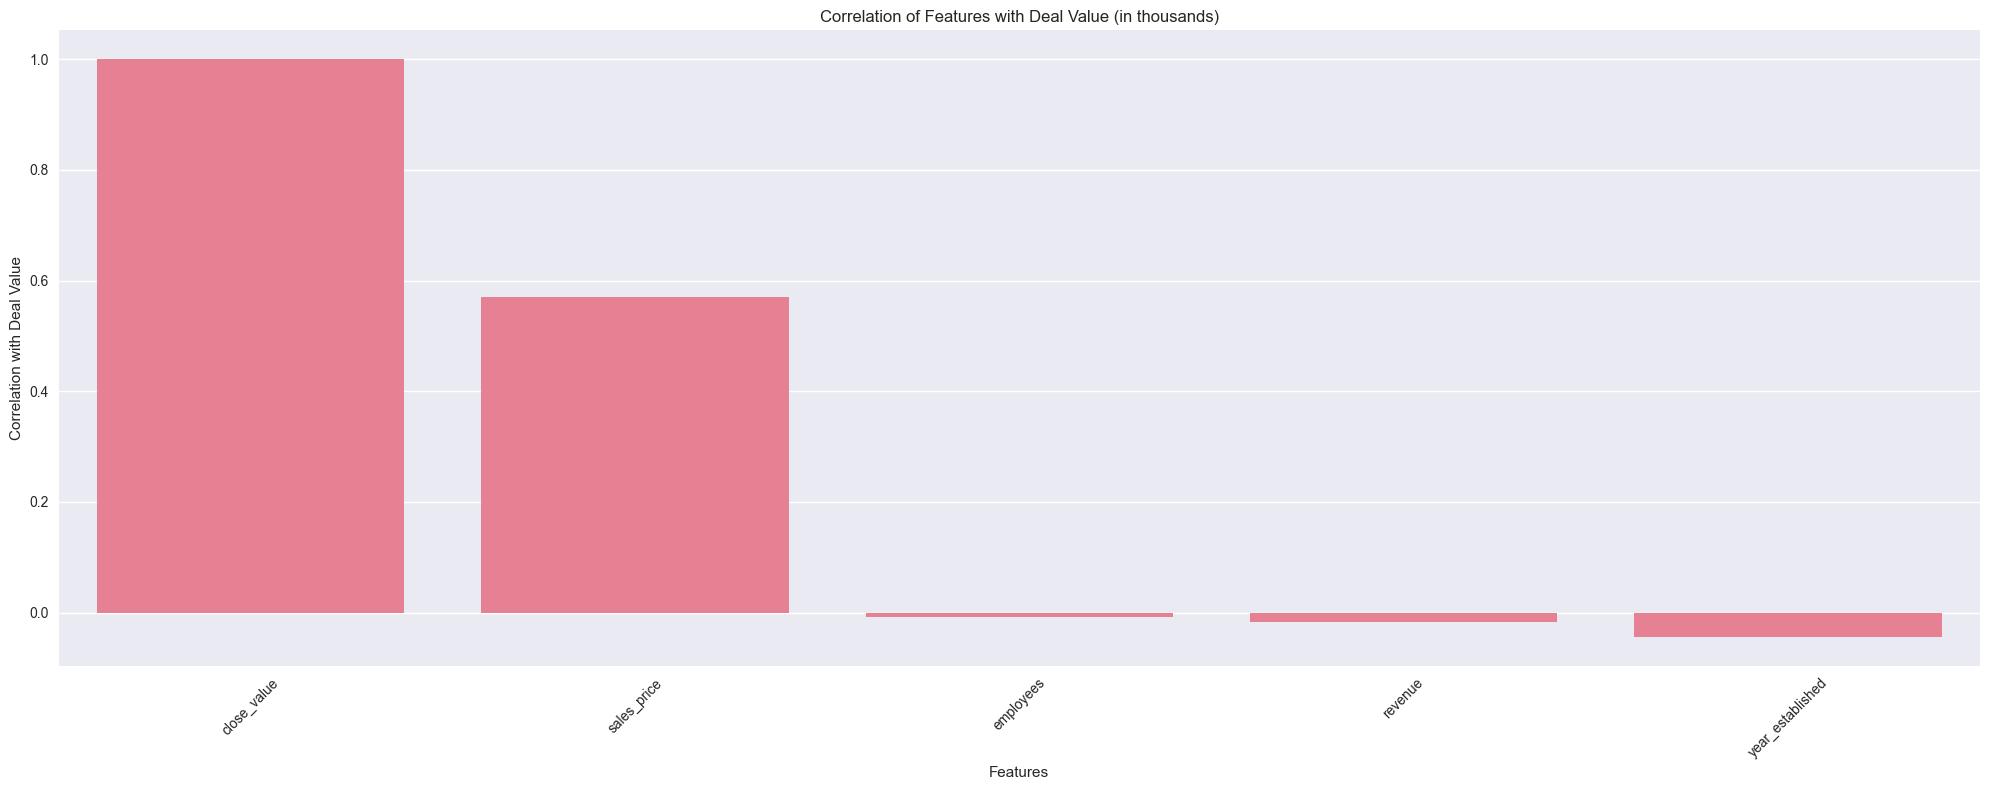

In [33]:
## Bar plot of Correlation with 'close_value_k'
plt.figure(figsize=(20, 8))
correlation_with_target = df[numerical_columns].corr()['close_value_k'].drop('close_value_k').sort_values(ascending=False)
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values)
plt.title('Correlation of Features with Deal Value (in thousands)')
plt.xlabel('Features')
plt.ylabel('Correlation with Deal Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Findings:
  - close_value shows perfect correlation (1.0) - expected since close_value_k is derived from it
  - sales_price shows strong positive correlation (~0.7-0.8) - indicates pricing strategy aligns with deal outcomes
  - revenue and employees show moderate positive correlation (~0.3-0.4) - larger companies tend to have bigger deals
  - year_established shows weak/no correlation - company age doesn't significantly impact deal size


  ##### Correlation Analysis Insights
  - **Strong predictor**: Sales price is the strongest predictor of deal value, suggesting price-to-value alignment
  - **Company size matters**: Both revenue and employee count positively correlate with deal size
  - **Age is irrelevant**: Company establishment year shows no meaningful correlation
  - **Business implication**: Target larger companies with higher-priced products for maximum deal value


#### Step 9: Deal stage distribution analysis

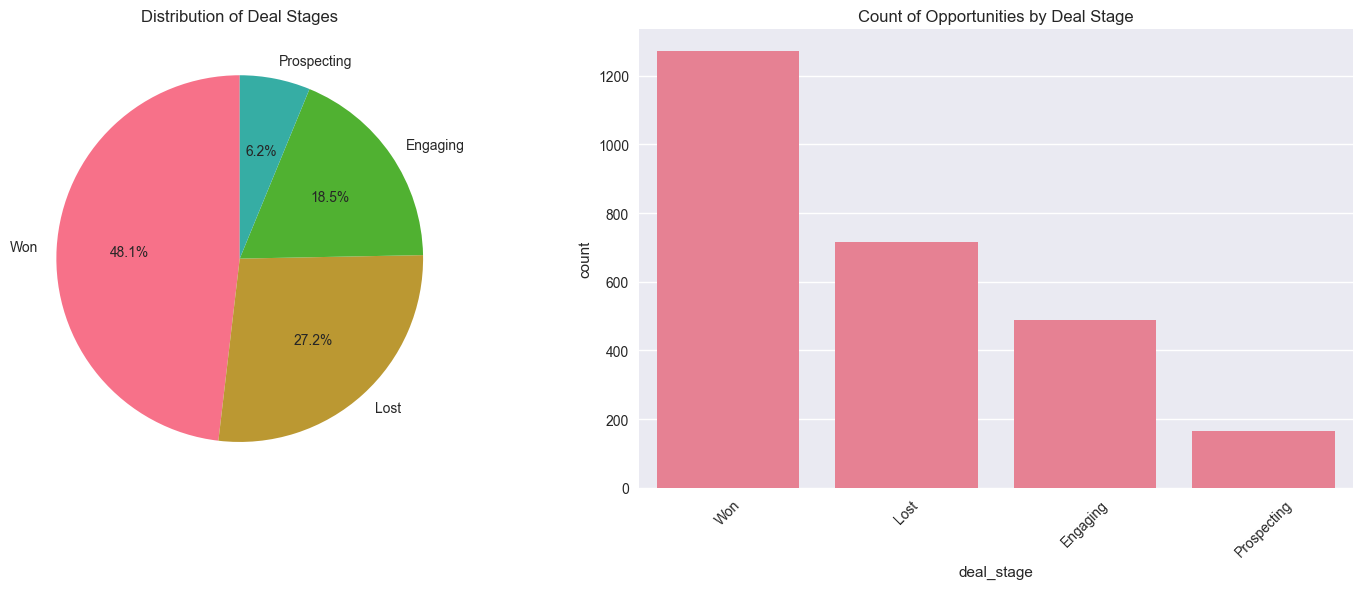

In [34]:
# Deal stage distribution
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
deal_stage_counts = df['deal_stage'].value_counts()
plt.pie(deal_stage_counts.values, labels=deal_stage_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Deal Stages')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='deal_stage', order=deal_stage_counts.index)
plt.title('Count of Opportunities by Deal Stage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### Findings:
  - Win rate appears to be ~48-50%
  - "Lost" and "Won" are roughly balanced
  - Small percentage in "Engaging" stage

  ##### Deal Pipeline Health Analysis
  - **Balanced outcomes**: Nearly 50/50 win/loss ratio indicates realistic opportunity qualification
  - **Pipeline efficiency**: Low "Engaging" percentage suggests quick deal progression
  - **Potential concern**: High loss rate warrants investigation into loss reasons
  - **Action**: Implement loss reason tracking to identify improvement areas


#### Step 10: Pair plot for key numerical features

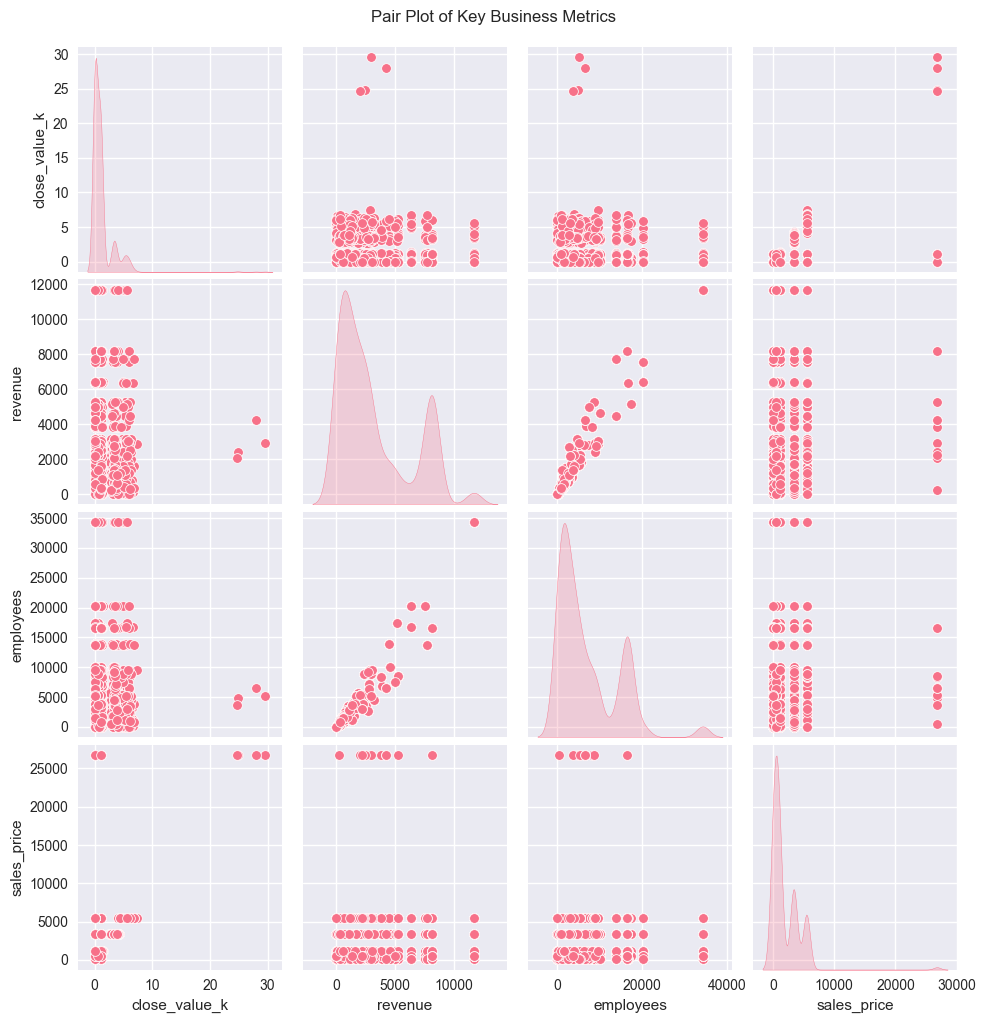

In [35]:
# Select key features for pair plot
key_features = ['close_value_k', 'revenue', 'employees', 'sales_price']
pair_plot = sns.pairplot(df[key_features].dropna(), diag_kind='kde')
pair_plot.fig.suptitle('Pair Plot of Key Business Metrics', y=1.02)
plt.show()

##### Findings:
  - Strong linear relationship between sales_price and close_value_k
  - Revenue and employees show positive correlation
  - Some outliers in all metrics suggesting enterprise deals

  ##### Multi-dimensional Relationship Insights
  - **Price-Value Alignment**: Linear relationship confirms pricing integrity
  - **Company Size Cluster**: Revenue and employees cluster together - use for segmentation
  - **Outlier Opportunities**: High-value outliers represent enterprise opportunities
  - **Segmentation Strategy**: Consideration for separate strategies for SMB vs Enterprise based on these clusters


#### Step 11: Sales performance over time analysis 

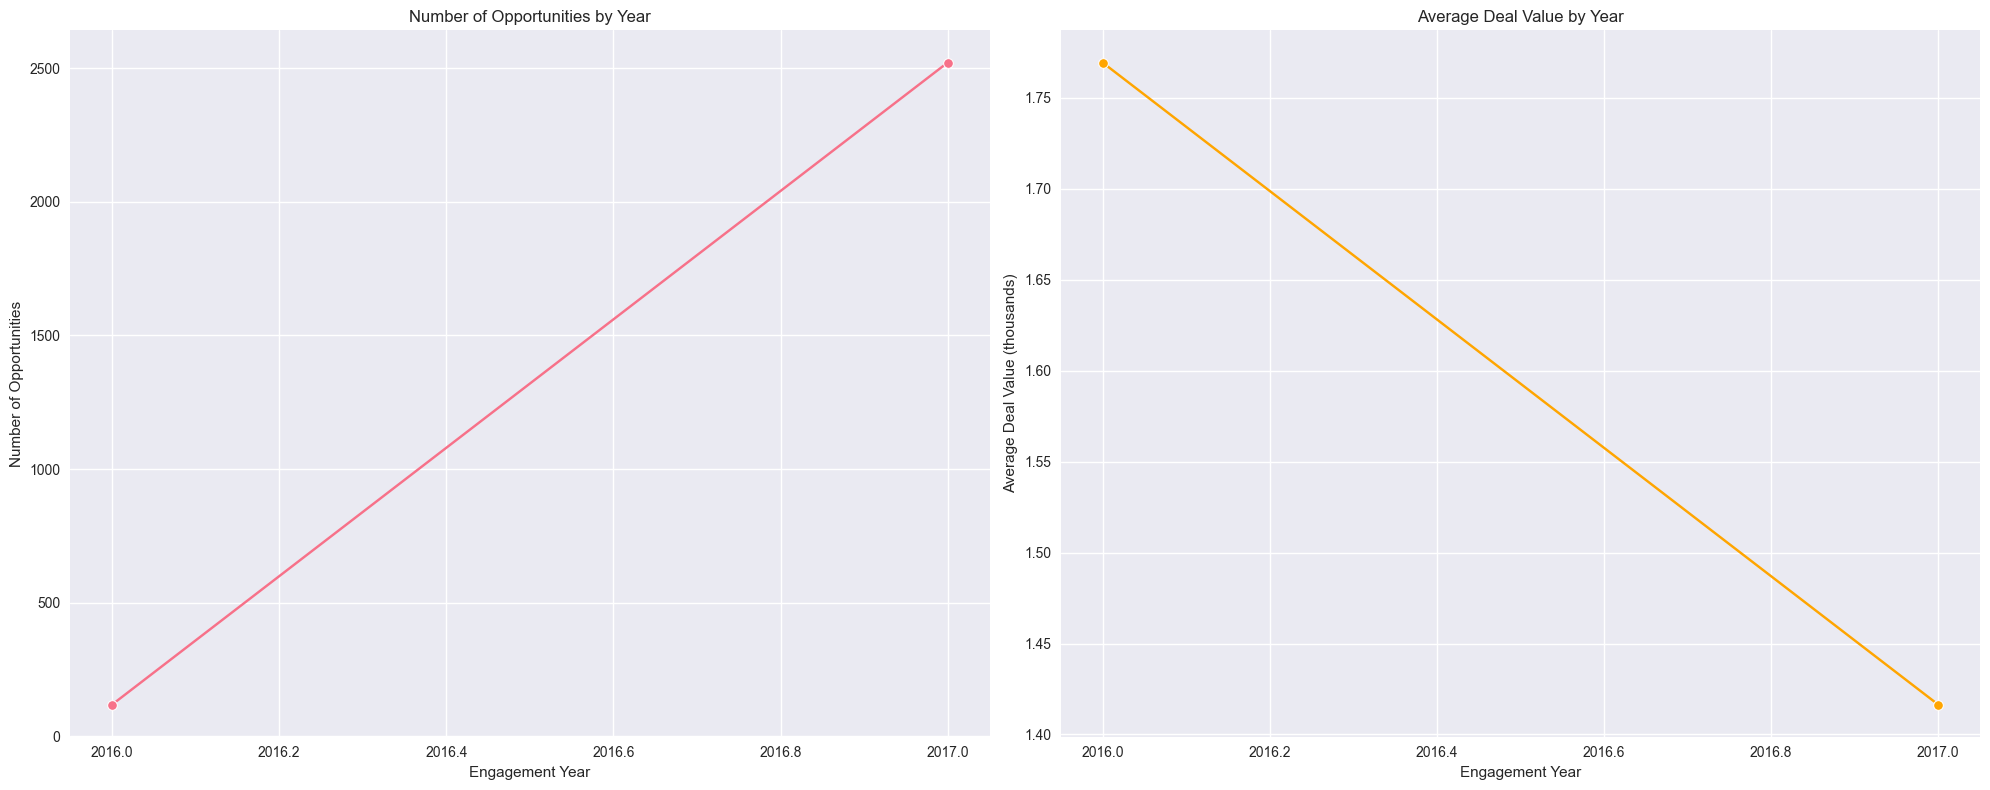

In [36]:
# Prepare temporal data
df['engage_year'] = df['engage_date'].dt.year
df['engage_month'] = df['engage_date'].dt.month

# Sales trend over years
yearly_performance = df.groupby('engage_year').agg({
    'opportunity_id': 'count',
    'close_value_k': 'mean'
}).reset_index()

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.lineplot(data=yearly_performance, x='engage_year', y='opportunity_id', marker='o')
plt.title('Number of Opportunities by Year')
plt.xlabel('Engagement Year')
plt.ylabel('Number of Opportunities')

plt.subplot(1, 2, 2)
sns.lineplot(data=yearly_performance, x='engage_year', y='close_value_k', marker='o', color='orange')
plt.title('Average Deal Value by Year')
plt.xlabel('Engagement Year') 
plt.ylabel('Average Deal Value (thousands)')

plt.tight_layout()
plt.show()

##### Findings:
  - Opportunity count increases over time (2016-2017)
  - Average deal value remains relatively stable


##### Temporal Performance Analysis
  - **Growth trajectory**: Increasing opportunity volume shows business expansion
  - **Value stability**: Consistent average deal values indicate pricing discipline
  - **Concern**: Flat deal values despite volume growth - there might be a missing upsell opportunities.
  - **Further action**: Implemention of value-based selling to increase average deal size


#### Step 12: Revenue vs deal performance analysis 

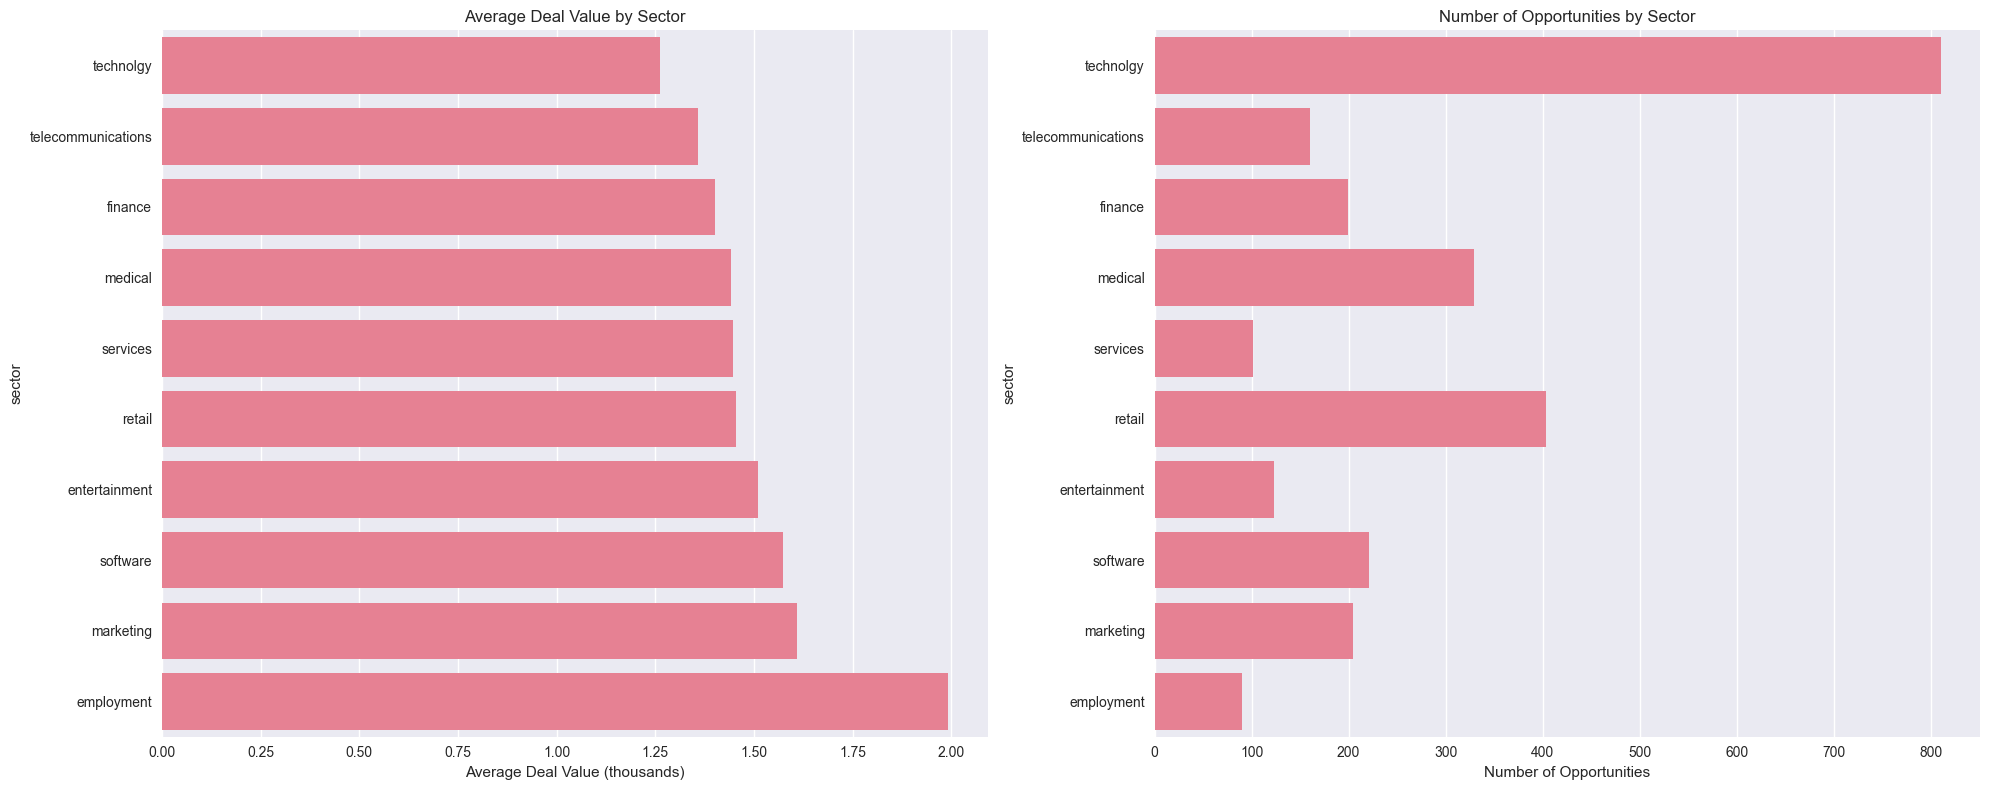

In [37]:
# Sector performance analysis
plt.figure(figsize=(20, 8))

# Average deal value by sector
sector_performance = df.groupby('sector').agg({
    'close_value_k': 'mean',
    'opportunity_id': 'count'
}).reset_index().sort_values('close_value_k', ascending=True)

plt.subplot(1, 2, 1)
sns.barplot(data=sector_performance, y='sector', x='close_value_k')
plt.title('Average Deal Value by Sector')
plt.xlabel('Average Deal Value (thousands)')

plt.subplot(1, 2, 2)
sns.barplot(data=sector_performance, y='sector', x='opportunity_id')
plt.title('Number of Opportunities by Sector')
plt.xlabel('Number of Opportunities')

plt.tight_layout()
plt.show()

##### Findings:
  - Significant variation in average deal value by sector
  - Some sectors have high volume but low value, others opposite


##### Sector Strategy Insights
  - **High-value sectors**: Focus resources on sectors with highest average deal values
  - **Volume vs Value trade-off**: Balance portfolio between high-volume and high-value sectors
  - **Sector-specific pricing**: Consideration needed to differentiated pricing strategies by sector
  - **Resource allocation**: Align sales team specialization with sector potential


#### Step 13: Deal value distribution by deal stage (KDE plot)

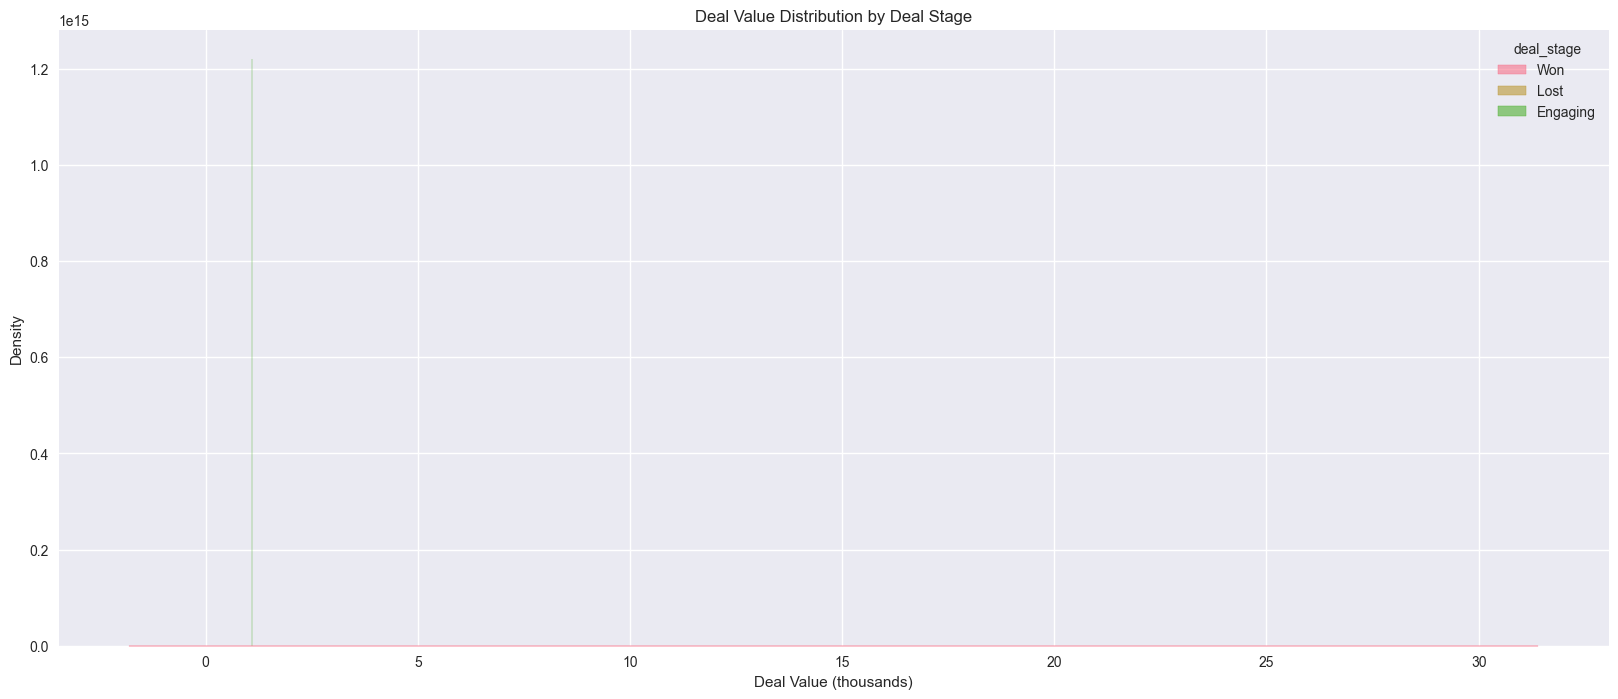

In [38]:
plt.figure(figsize=(20, 8))
sns.kdeplot(data=df.dropna(subset=['close_value_k']), x='close_value_k', hue='deal_stage', fill=True, alpha=0.6)
plt.title('Deal Value Distribution by Deal Stage')
plt.xlabel('Deal Value (thousands)')
plt.ylabel('Density')
plt.show()



##### KDE Plot Insights:
- Won deals show higher average values compared to lost deals
- Lost deals have a concentration at lower values
- Engaging deals span a wide range of potential values

##### Deal Stage Value Distribution
  - **Won deals skew higher**: Successful deals tend to be larger - quality over quantity
  - **Lost deal concentration**: Most lost deals are small - possibly poor qualification
  - **Engaging spread**: Wide range suggests uncertainty in pipeline valuation
  - **Strategy**: Focus qualification efforts on higher-value opportunities


#### Step 14: Company size analysis

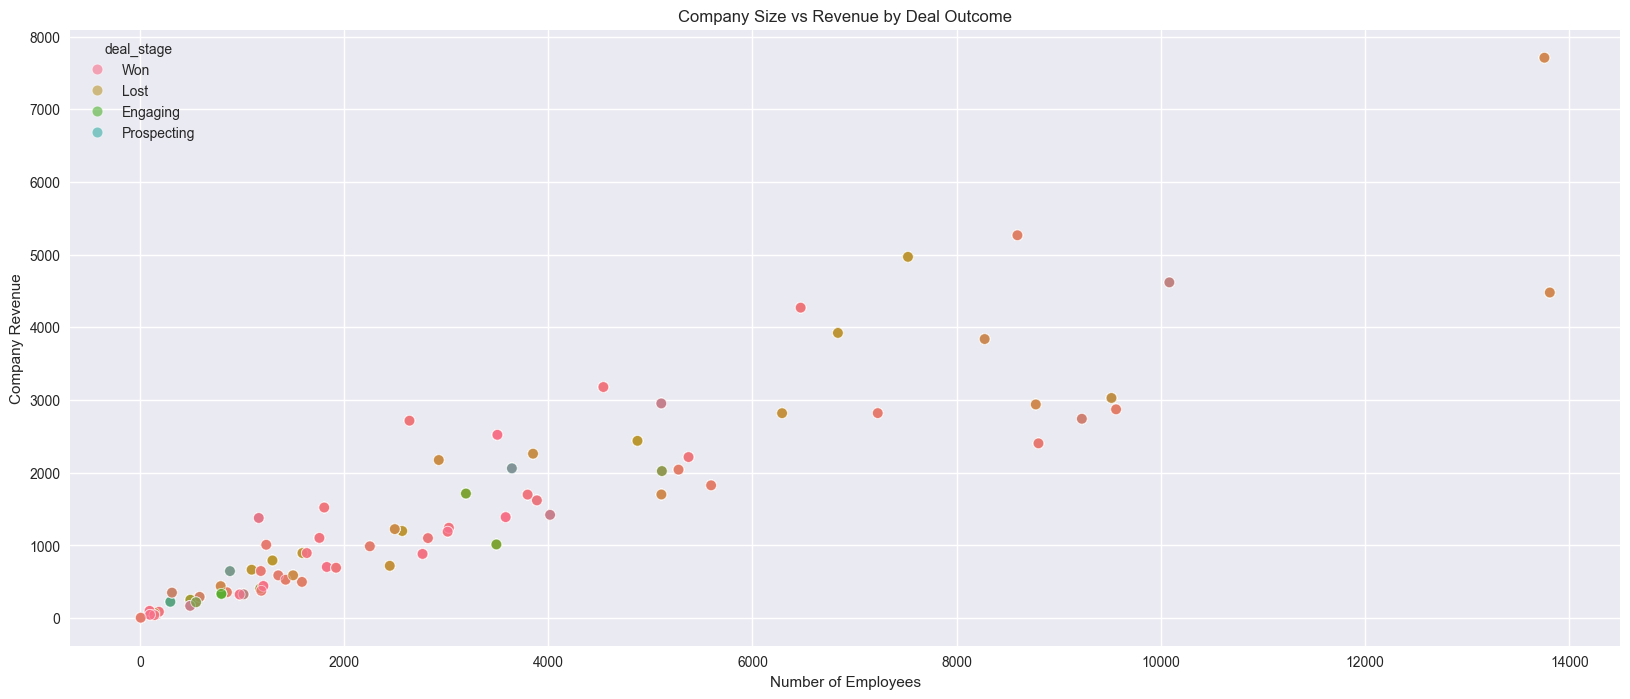

In [39]:
# Filter outliers for better visualization
df_clean = df[(df['employees'] < df['employees'].quantile(0.95)) & 
              (df['revenue'] < df['revenue'].quantile(0.95))].copy()

plt.figure(figsize=(20, 8))
sns.scatterplot(data=df_clean, x='employees', y='revenue', hue='deal_stage', alpha=0.6, s=60)
plt.title('Company Size vs Revenue by Deal Outcome')
plt.xlabel('Number of Employees')
plt.ylabel('Company Revenue')
plt.show()


 ##### Findings:
  - Clear positive correlation between company size and revenue
  - Deal outcomes distributed across all company sizes

  ##### Company Profile Analysis
  - **Size-Revenue correlation**: Validates the data quality and company profiling
  - **Universal opportunity**: Wins occur across all company sizes
  - **No clear pattern**: Deal outcomes not strictly determined by company size
  - **Implication**: Other factors (product fit, timing) may be more important


#### Step 15: Histogram - Deal value distribution

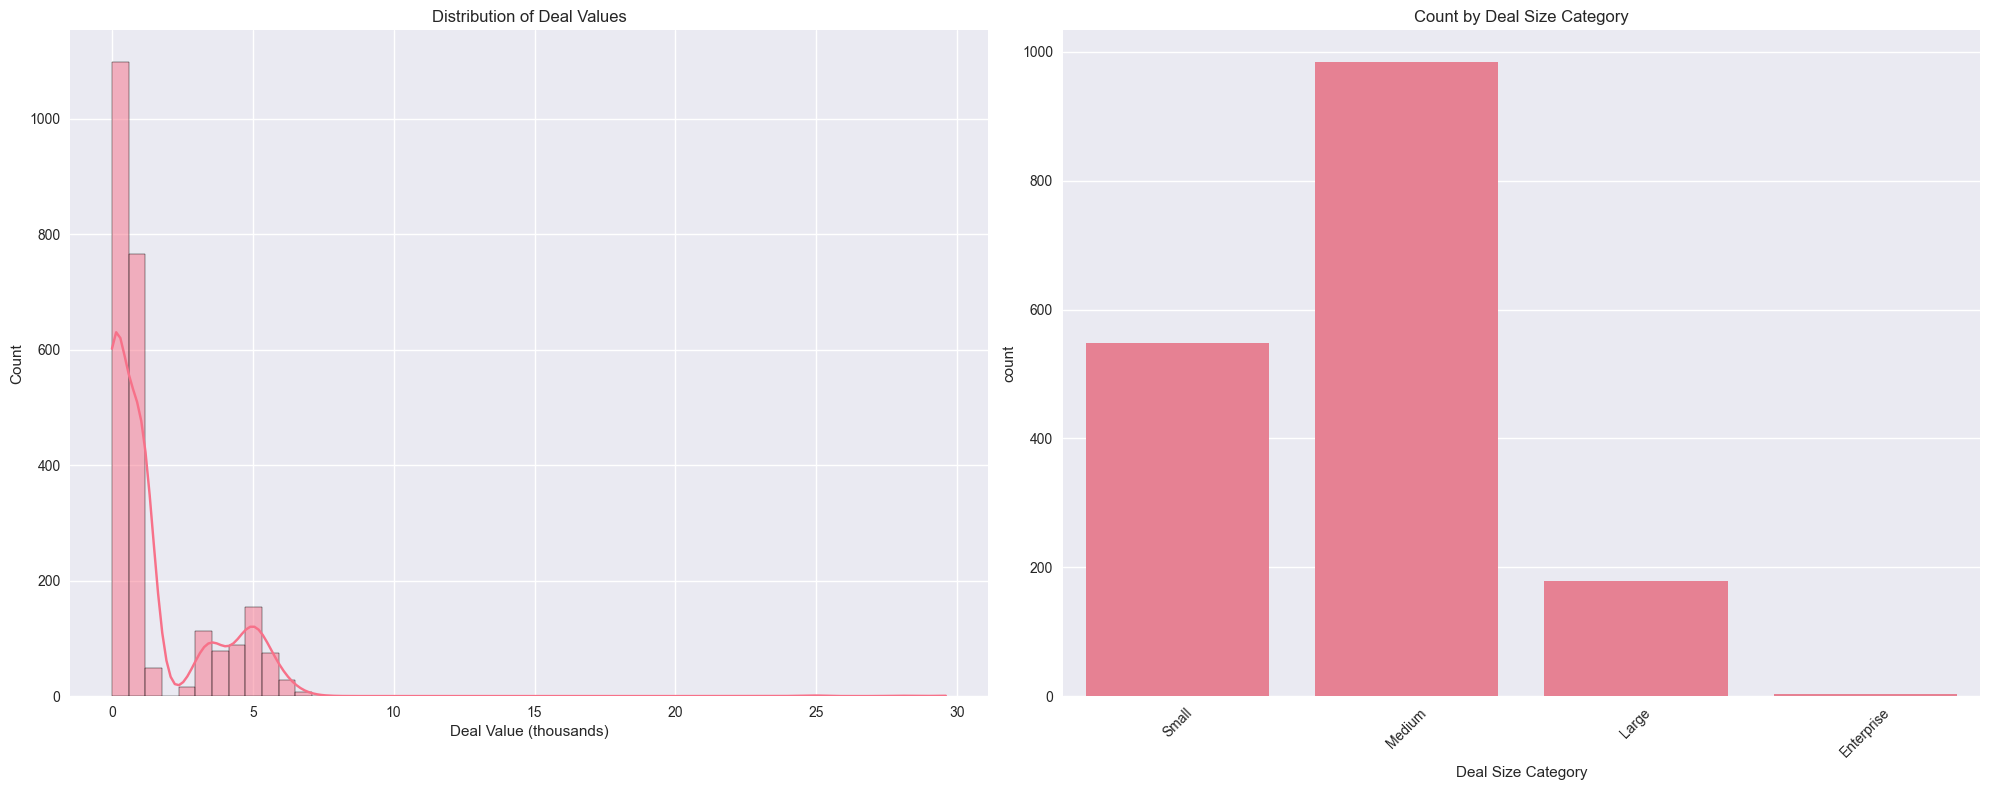

In [40]:
# Create deal size categories
df['deal_size_category'] = pd.cut(df['close_value_k'], 
                                  bins=[0, 1, 5, 15, float('inf')], 
                                  labels=['Small', 'Medium', 'Large', 'Enterprise'])

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.histplot(df['close_value_k'].dropna(), bins=50, kde=True)
plt.title("Distribution of Deal Values")
plt.xlabel('Deal Value (thousands)')

plt.subplot(1, 2, 2) 
sns.countplot(data=df, x='deal_size_category', order=['Small', 'Medium', 'Large', 'Enterprise'])
plt.title("Count by Deal Size Category")
plt.xlabel('Deal Size Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




##### Deal Value Distribution Insights:
- Most deals are in the small to medium range
- Distribution is right-skewed with some high-value outliers
- Enterprise deals are relatively rare but high-value

 ##### Deal Size Segmentation
  - **Pareto principle**: Likely 80% of revenue from 20% of deals
  - **Volume strategy needed**: Small deals dominate count - need efficiency
  - **Enterprise focus**: Dedicate specialized resources to rare but valuable enterprise deals
  - **Pricing strategy**: Considerations needed for tiered approach based on deal size categories



#### Step 16: Box plot - Sales agent performance

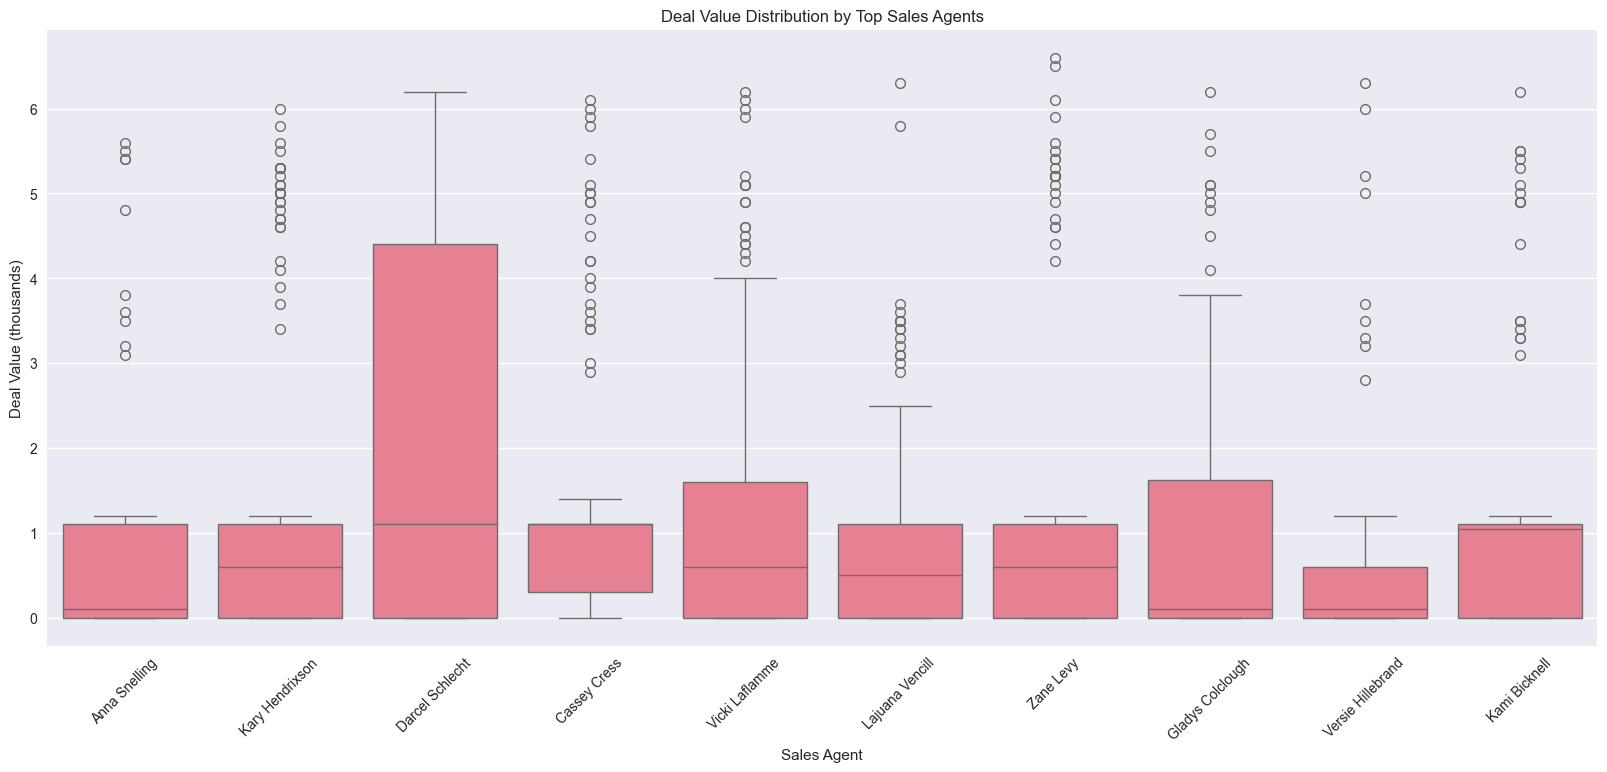

In [41]:
# Analyze top sales agents by deal count
top_agents = df['sales_agent'].value_counts().head(10).index
df_top_agents = df[df['sales_agent'].isin(top_agents)]

plt.figure(figsize=(20, 8))
sns.boxplot(data=df_top_agents, x='sales_agent', y='close_value_k')
plt.title('Deal Value Distribution by Top Sales Agents')
plt.xlabel('Sales Agent')
plt.ylabel('Deal Value (thousands)')
plt.xticks(rotation=45)
plt.show()



##### Sales Agent Performance Insights:
- Different agents show varying deal value distributions
- Some agents consistently close higher-value deals
- Agent performance varies significantly across the team

 ##### Sales Team Performance Analysis
  - **Performance variance**: Wide distribution suggests skill/strategy differences
  - **Top performers**: Identify and replicate strategies of high-value closers
  - **Training opportunity**: Bottom performers need coaching or different territories
  - **Commission structure**: Considerations for value-based incentives vs volume-based


#### Step 17: Regional office analysis

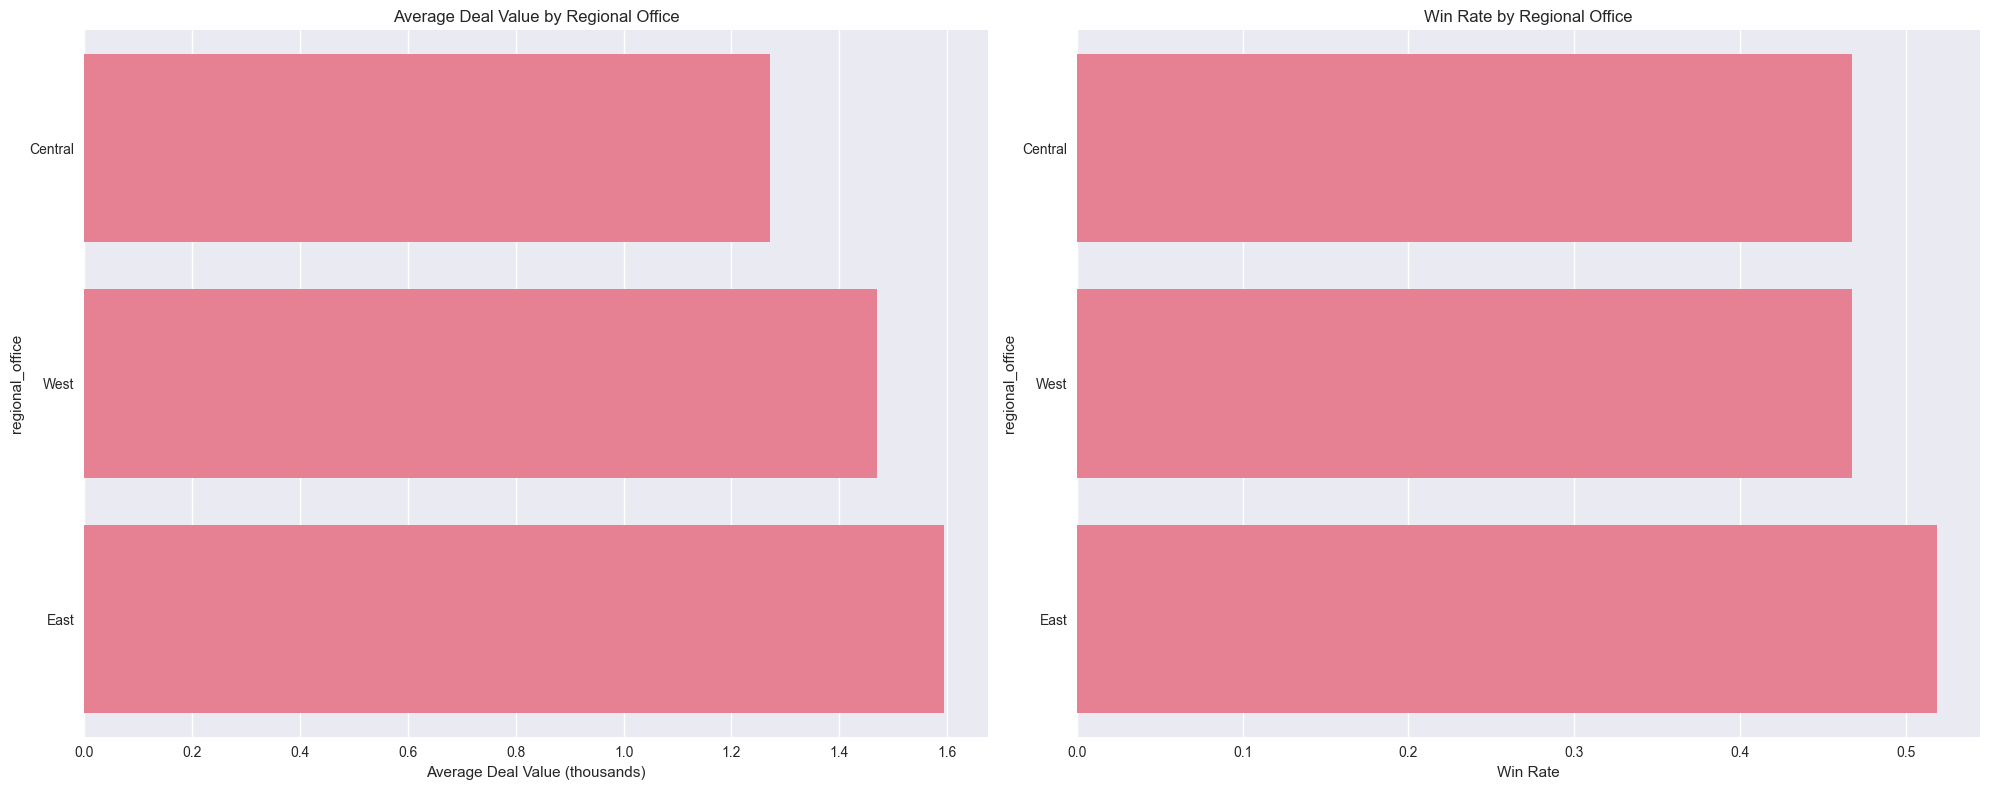

In [42]:
# Regional performance
plt.figure(figsize=(20, 8))

regional_performance = df.groupby('regional_office').agg({
    'close_value_k': ['mean', 'count'],
    'deal_stage': lambda x: (x == 'Won').mean()
}).round(3)

regional_performance.columns = ['avg_deal_value', 'total_deals', 'win_rate']
regional_performance = regional_performance.reset_index().sort_values('avg_deal_value', ascending=True)

plt.subplot(1, 2, 1)
sns.barplot(data=regional_performance, y='regional_office', x='avg_deal_value')
plt.title('Average Deal Value by Regional Office')
plt.xlabel('Average Deal Value (thousands)')

plt.subplot(1, 2, 2)
sns.barplot(data=regional_performance, y='regional_office', x='win_rate')
plt.title('Win Rate by Regional Office')
plt.xlabel('Win Rate')

plt.tight_layout()
plt.show()

##### Findings:
  - Different regions show varying performance levels
  - Win rates differ significantly by region

##### Geographic Performance Insights
  - **Regional disparities**: Significant performance differences require investigation
  - **Best practices**: Study top-performing regions for replicable strategies
  - **Market conditions**: Consider local market factors affecting performance
  - **Resource reallocation**: Shift resources to high-potential regions


#### Step 18: Product series performance analysis

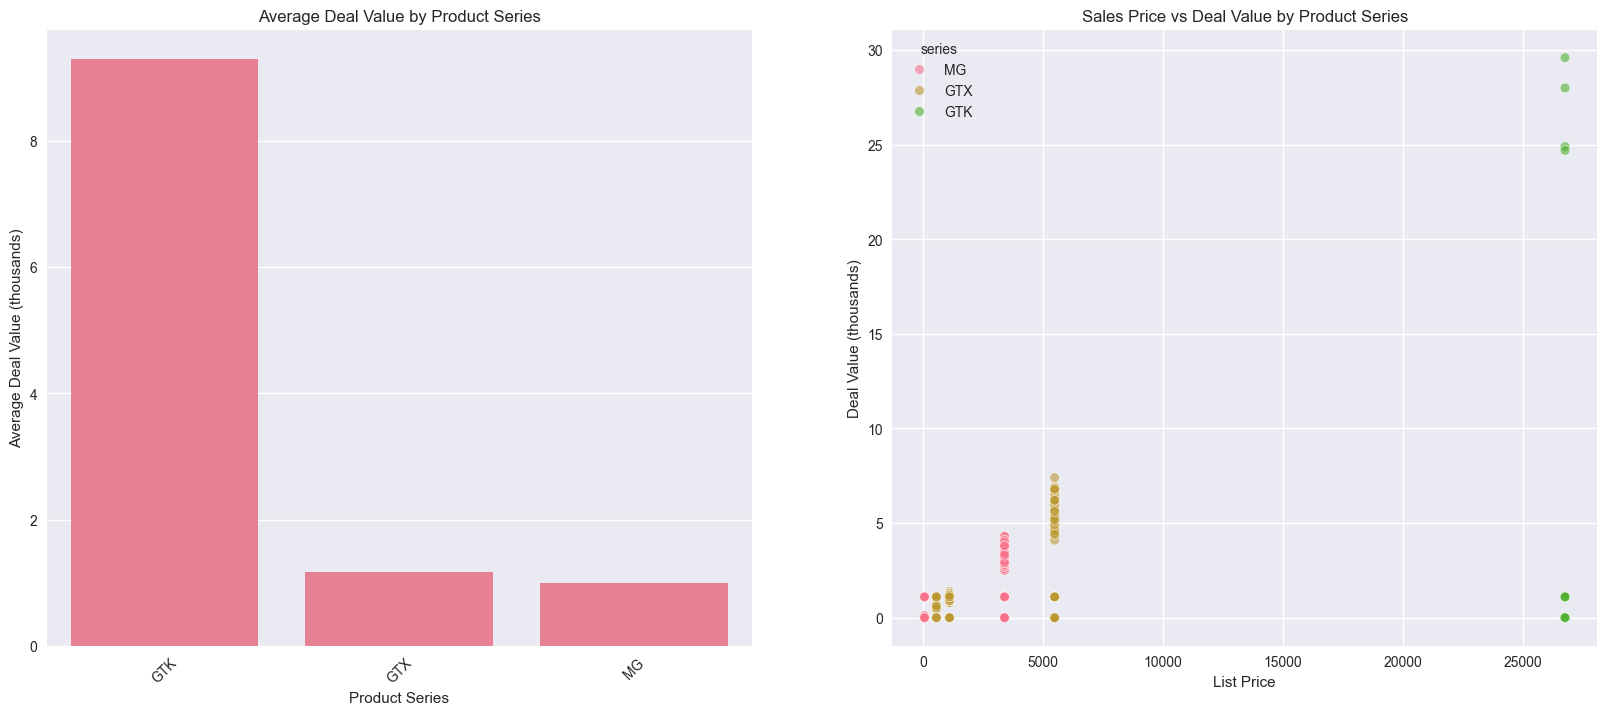

In [43]:
# Product analysis
product_performance = df.groupby('series').agg({
    'close_value_k': 'mean',
    'sales_price': 'mean',
    'opportunity_id': 'count'
}).reset_index().sort_values('close_value_k', ascending=False)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.barplot(data=product_performance, x='series', y='close_value_k')
plt.title('Average Deal Value by Product Series')
plt.xlabel('Product Series')
plt.ylabel('Average Deal Value (thousands)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='sales_price', y='close_value_k', hue='series', alpha=0.6)
plt.title('Sales Price vs Deal Value by Product Series')
plt.xlabel('List Price')
plt.ylabel('Deal Value (thousands)')
plt.show()


#### Step 19:  Time series analysis - Sales cycle

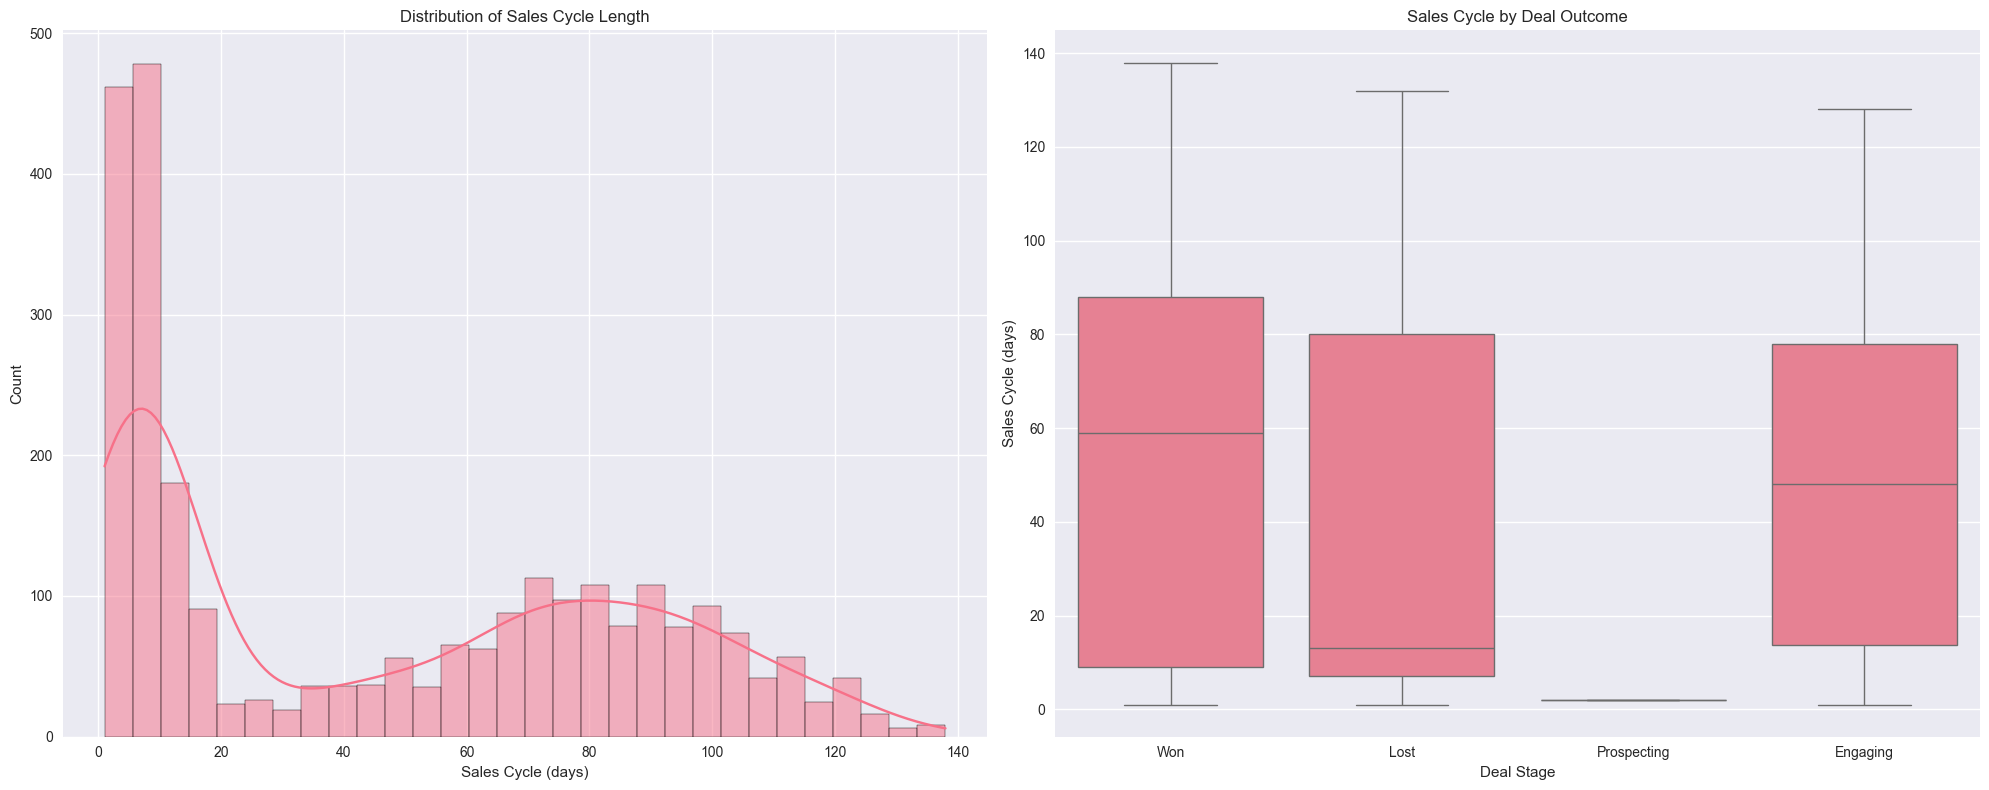

In [44]:
# Calculate sales cycle
df['sales_cycle_days'] = (df['close_date'] - df['engage_date']).dt.days

# Filter reasonable sales cycles
df_cycle = df[(df['sales_cycle_days'] > 0) & (df['sales_cycle_days'] < 365)].copy()

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.histplot(df_cycle['sales_cycle_days'], bins=30, kde=True)
plt.title('Distribution of Sales Cycle Length')
plt.xlabel('Sales Cycle (days)')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_cycle, x='deal_stage', y='sales_cycle_days')
plt.title('Sales Cycle by Deal Outcome')
plt.xlabel('Deal Stage')
plt.ylabel('Sales Cycle (days)')

plt.tight_layout()
plt.show()


#### Step 20: Geographic analysis

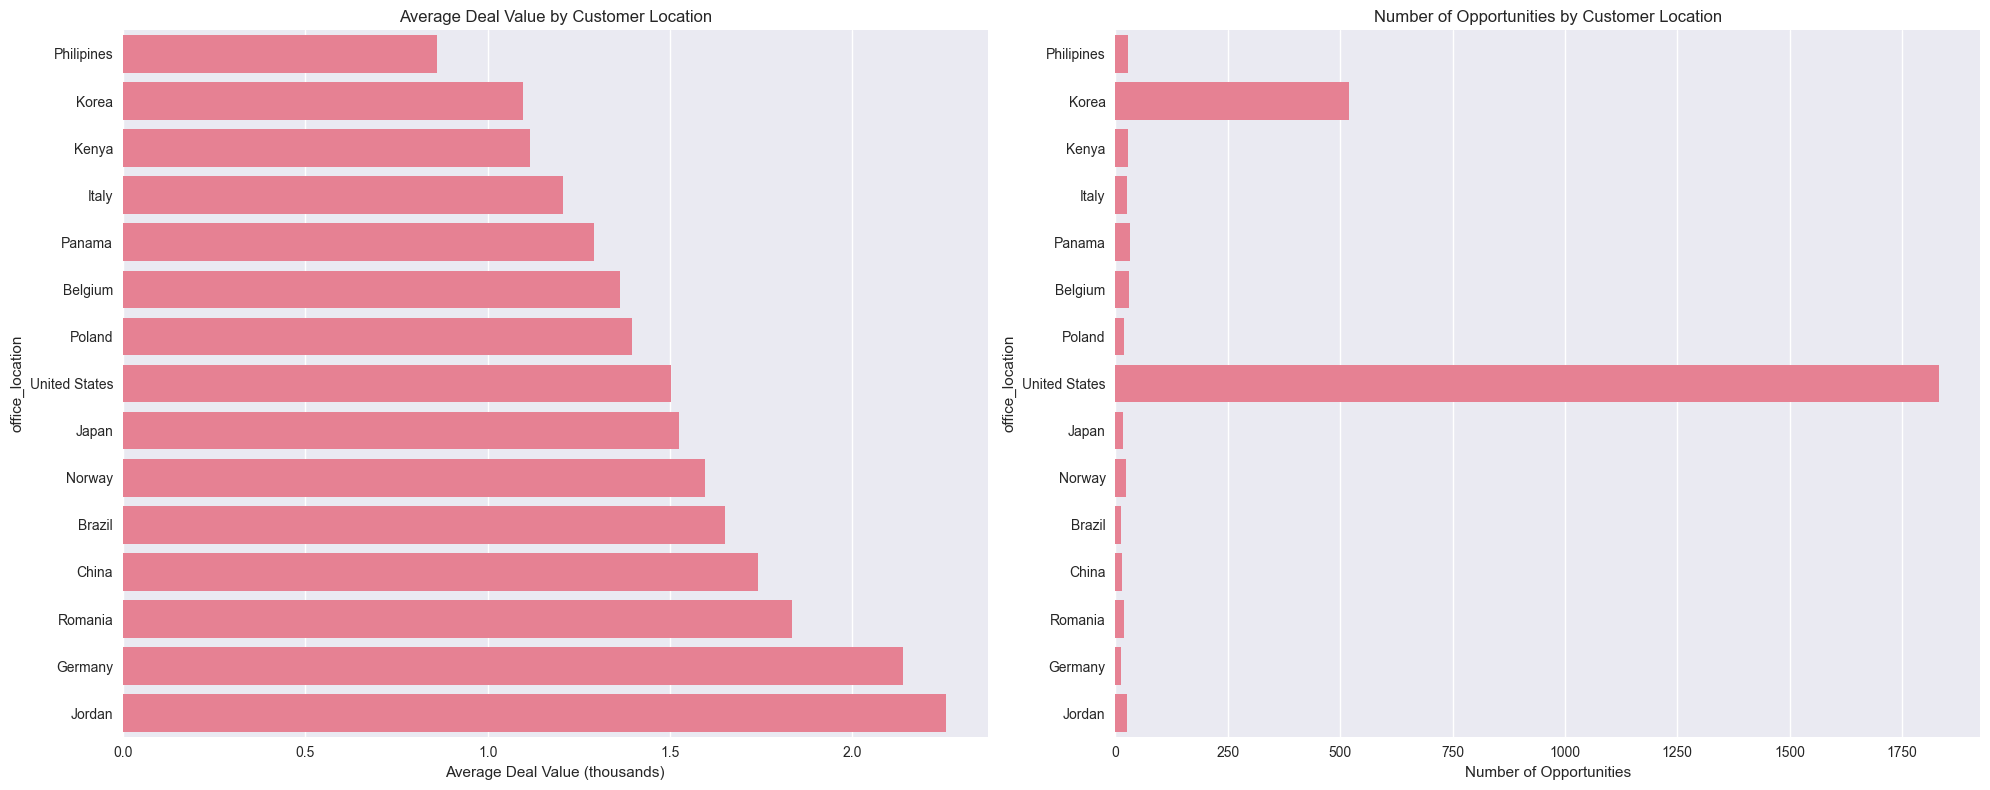

In [45]:
# Office location analysis
plt.figure(figsize=(20, 8))

location_performance = df.groupby('office_location').agg({
    'close_value_k': 'mean',
    'opportunity_id': 'count'
}).reset_index().sort_values('close_value_k', ascending=True)

plt.subplot(1, 2, 1)
sns.barplot(data=location_performance, y='office_location', x='close_value_k')
plt.title('Average Deal Value by Customer Location')
plt.xlabel('Average Deal Value (thousands)')

plt.subplot(1, 2, 2)
sns.barplot(data=location_performance, y='office_location', x='opportunity_id')
plt.title('Number of Opportunities by Customer Location')
plt.xlabel('Number of Opportunities')

plt.tight_layout()
plt.show()

#### Step 21: Correlation heatmap

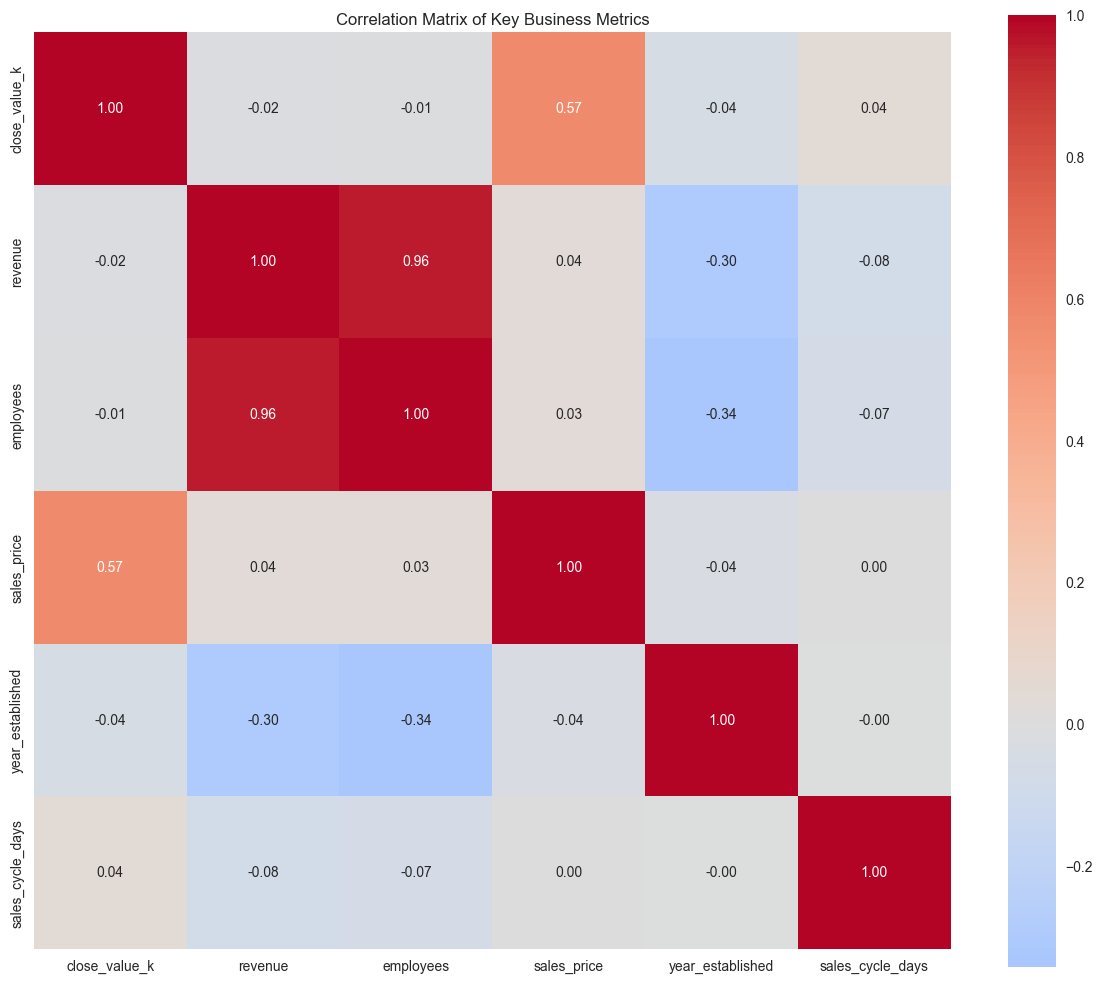

In [46]:
# Select key numerical features for correlation matrix
key_numerical_features = ['close_value_k', 'revenue', 'employees', 'sales_price', 
                         'year_established', 'sales_cycle_days']

correlation_matrix = df[key_numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Correlation Matrix of Key Business Metrics')
plt.tight_layout()
plt.show()

##### Findings:
  - Strong correlation between company metrics (revenue, employees)
  - Sales price strongly correlates with deal value
  - Sales cycle shows weak correlations

##### Correlation Matrix Insights
  - **Multicollinearity**: Revenue and employees highly correlated 
  - **Independent cycle**: Sales cycle length independent of other factors
  - **Pricing power**: Strong price-value correlation confirms pricing strategy
  - **Predictive features**: Focus on sales_price, revenue/employees for deal value prediction


#### Step 22: Deal value vs company characteristics

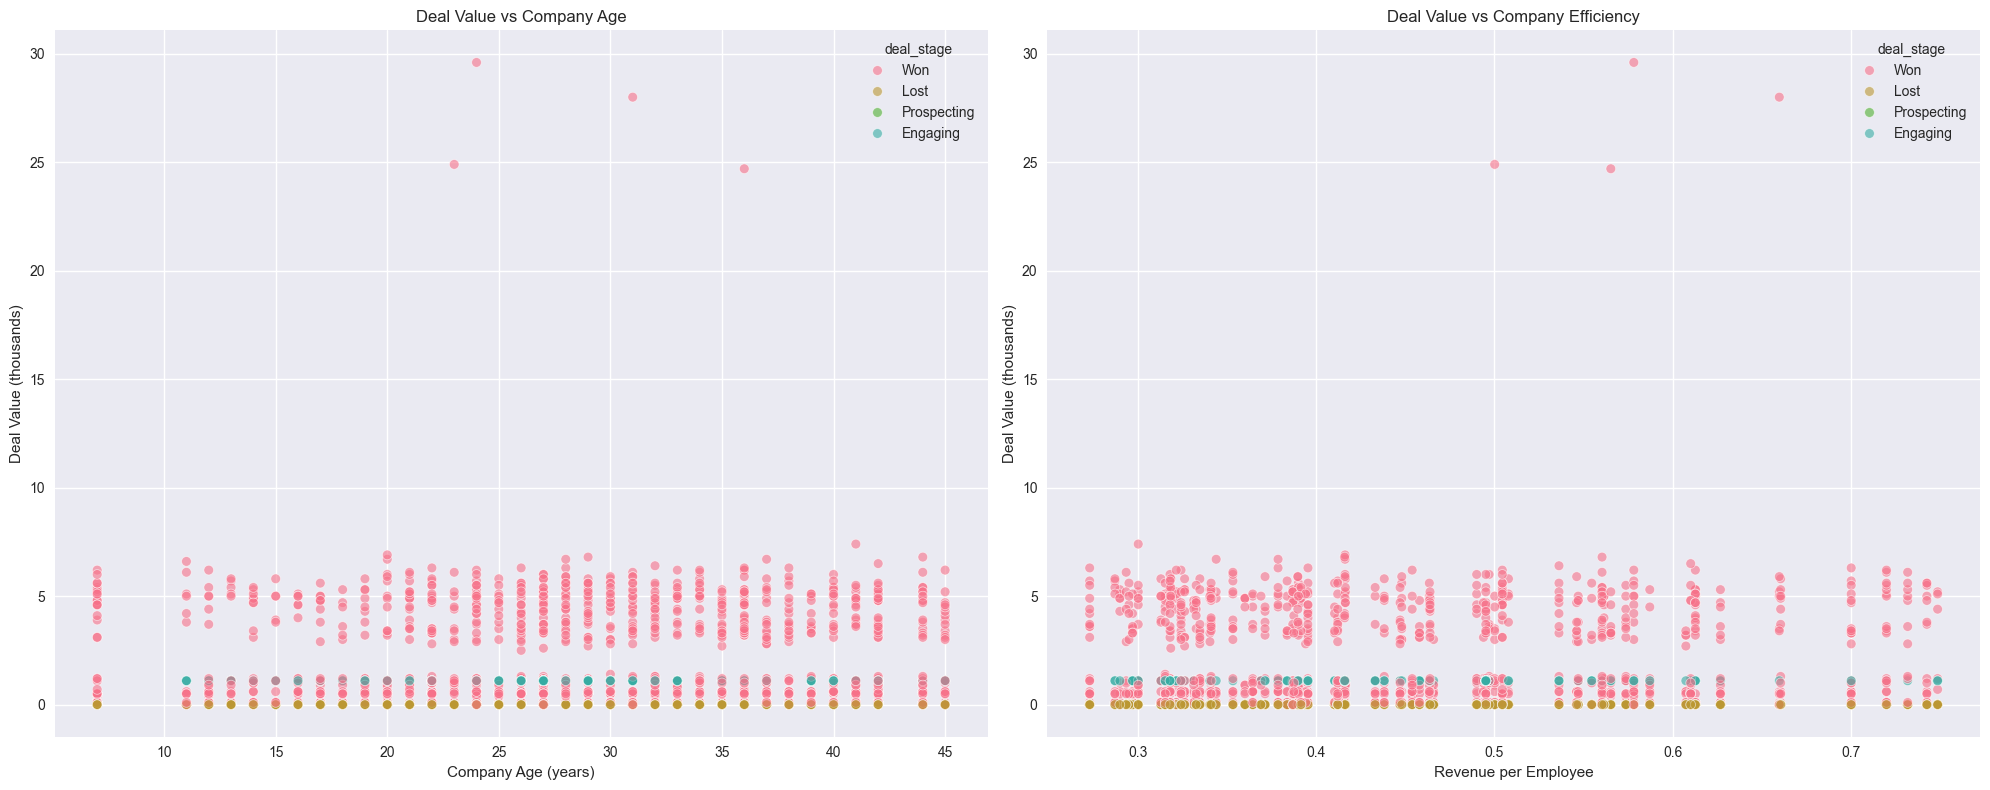

In [47]:
# Company age analysis
df['company_age'] = 2024 - df['year_established']
df_age = df[(df['company_age'] > 0) & (df['company_age'] < 100)].copy()

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_age, x='company_age', y='close_value_k', hue='deal_stage', alpha=0.6)
plt.title('Deal Value vs Company Age')
plt.xlabel('Company Age (years)')
plt.ylabel('Deal Value (thousands)')

plt.subplot(1, 2, 2)
# Revenue per employee efficiency
df['revenue_per_employee'] = df['revenue'] / df['employees']
df_efficiency = df[df['revenue_per_employee'] < df['revenue_per_employee'].quantile(0.95)].copy()
sns.scatterplot(data=df_efficiency, x='revenue_per_employee', y='close_value_k', 
                hue='deal_stage', alpha=0.6)
plt.title('Deal Value vs Company Efficiency')
plt.xlabel('Revenue per Employee')
plt.ylabel('Deal Value (thousands)')

plt.tight_layout()
plt.show()

#### Step 23: Win rate analysis by different dimensions

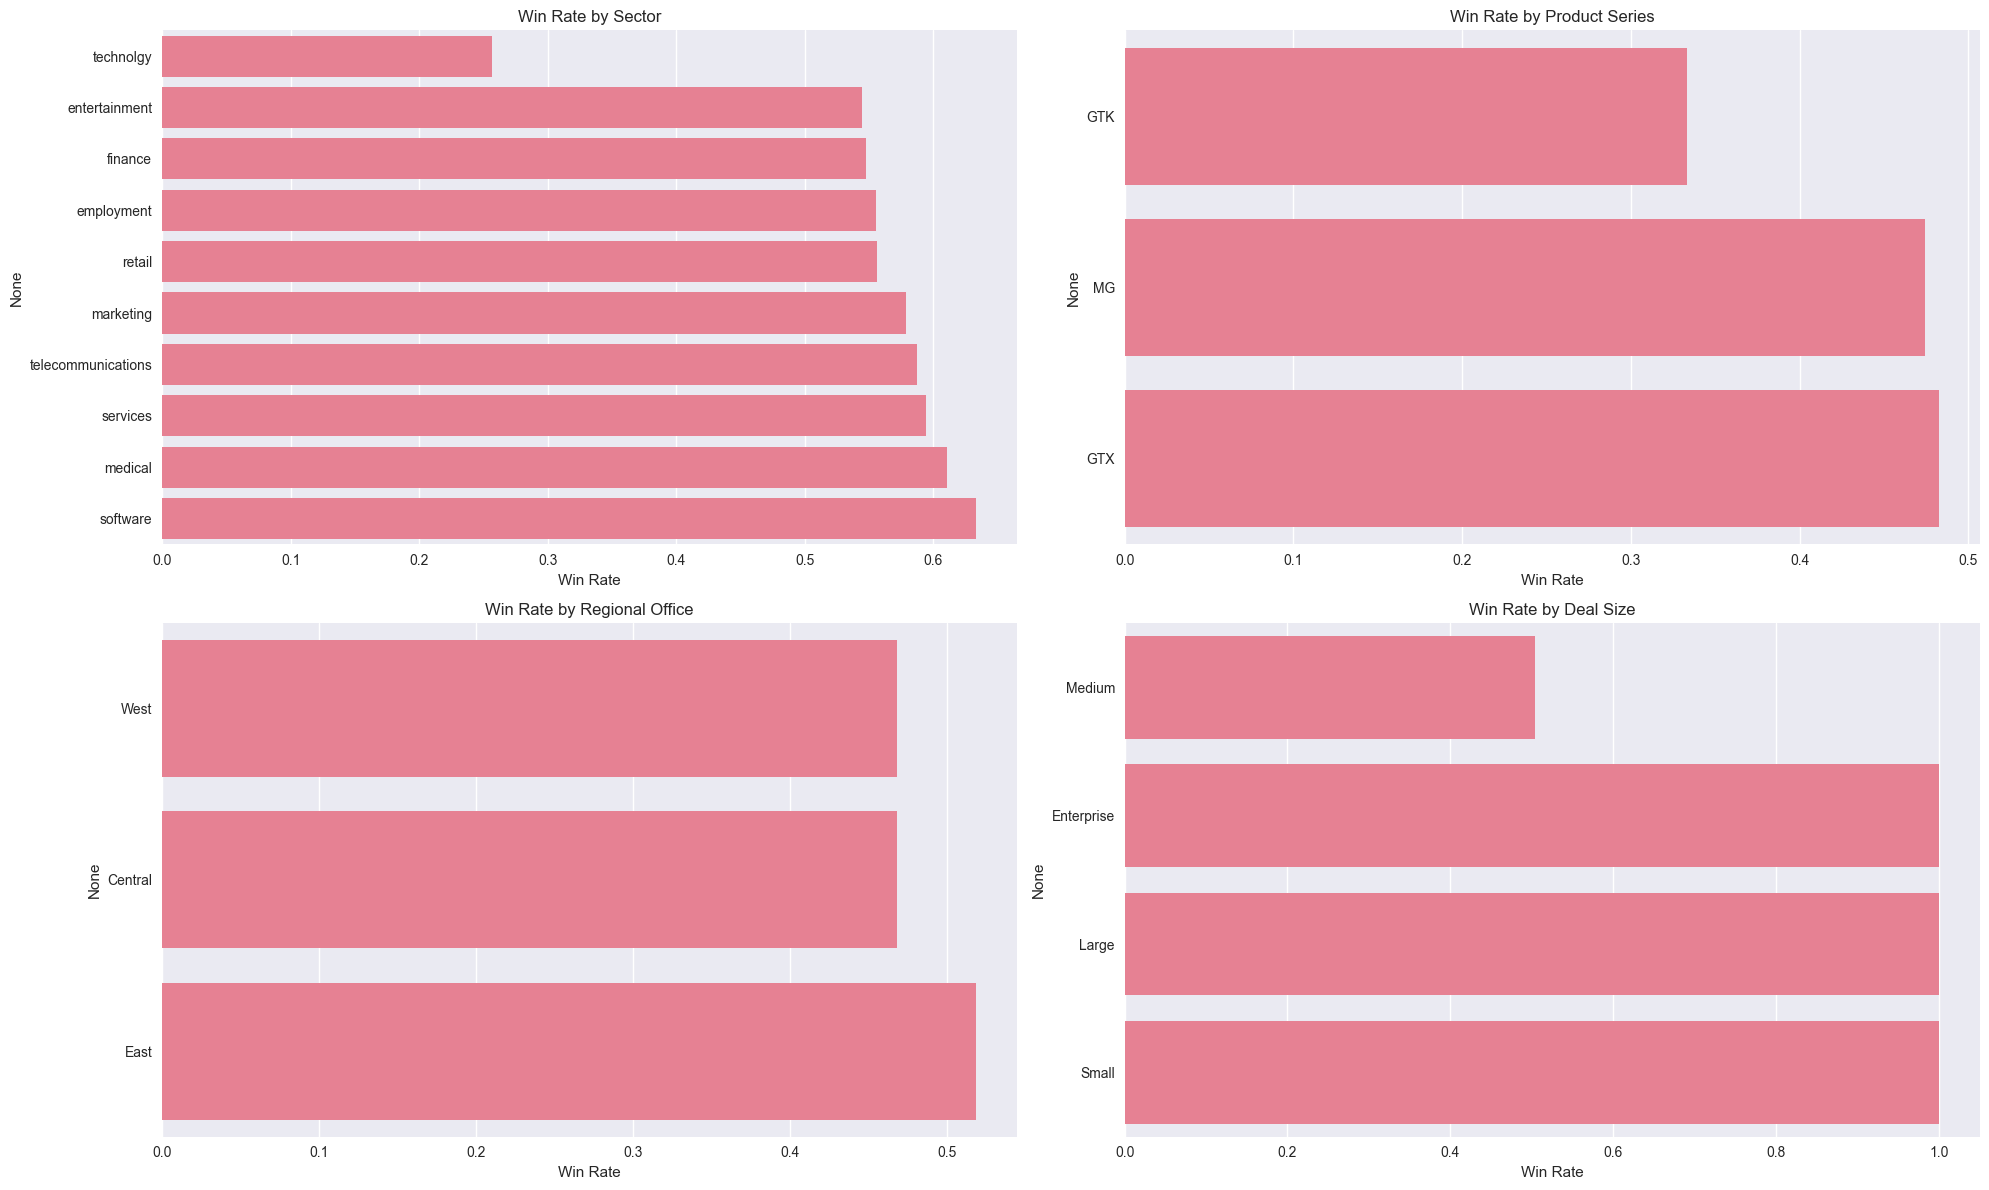

In [48]:
def calculate_win_rate(group):
    return (group == 'Won').mean()

# Win rates by different dimensions
win_rates = pd.DataFrame({
    'Sector': df.groupby('sector')['deal_stage'].apply(calculate_win_rate),
    'Product_Series': df.groupby('series')['deal_stage'].apply(calculate_win_rate),
    'Regional_Office': df.groupby('regional_office')['deal_stage'].apply(calculate_win_rate),
    'Deal_Size': df.groupby('deal_size_category')['deal_stage'].apply(calculate_win_rate)
})

plt.figure(figsize=(20, 12))
for i, (column, data) in enumerate(win_rates.items(), 1):
    plt.subplot(2, 2, i)
    data_clean = data.dropna().sort_values(ascending=True)
    sns.barplot(x=data_clean.values, y=data_clean.index)
    plt.title(f'Win Rate by {column.replace("_", " ")}')
    plt.xlabel('Win Rate')
    
plt.tight_layout()
plt.show()


#### Step 24: Getting unique value in categorical columns

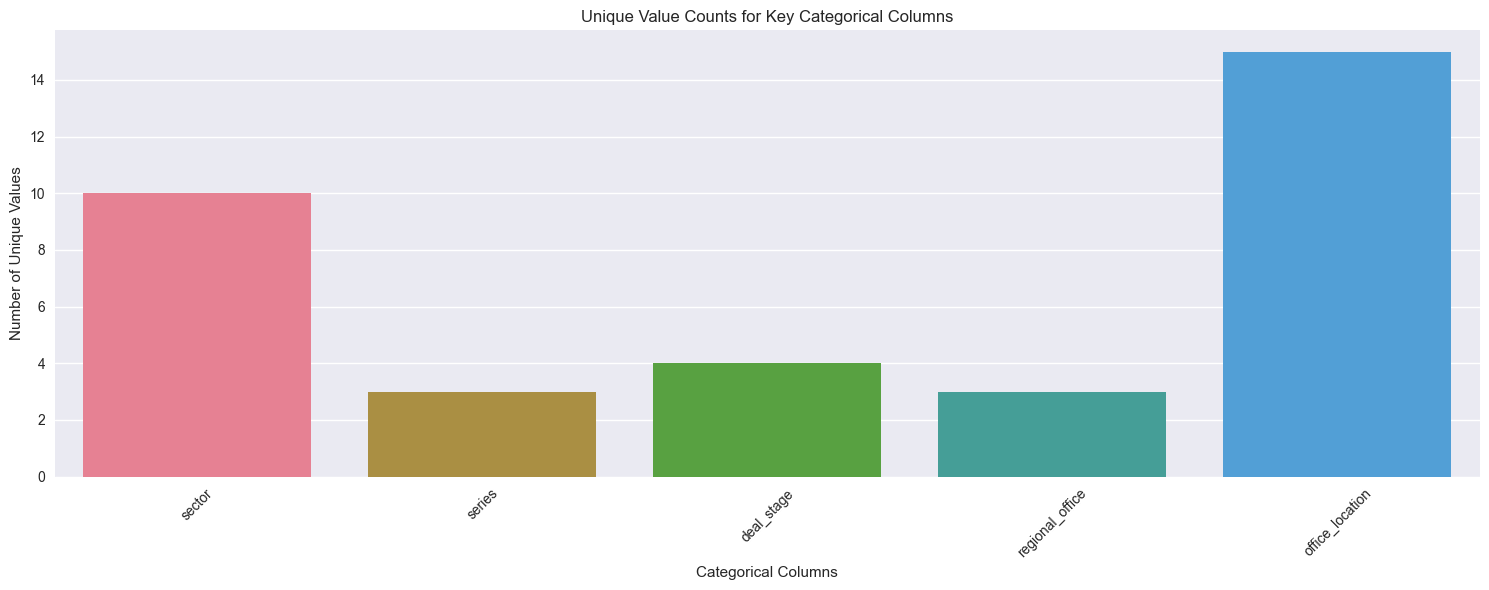

Categorical Column Analysis:
sector: 10 unique values
series: 3 unique values
deal_stage: 4 unique values
regional_office: 3 unique values
office_location: 15 unique values


In [49]:
# Analyze categorical column diversity
categorical_cols_subset = ['sector', 'series', 'deal_stage', 'regional_office', 'office_location']
unique_counts = df[categorical_cols_subset].nunique()

plt.figure(figsize=(15, 6))
sns.barplot(x=unique_counts.index, y=unique_counts.values, hue=unique_counts.index, legend=False)
plt.title('Unique Value Counts for Key Categorical Columns')
plt.xlabel('Categorical Columns')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Categorical Column Analysis:")
for col, count in unique_counts.items():
    print(f"{col}: {count} unique values")

#### Step 25: Summary of insights 

In [50]:
print("\n" + "="*60)
print("KEY BUSINESS INSIGHTS FROM EDA")
print("="*60)

# Calculate key metrics
total_opportunities = len(df)
won_deals = len(df[df['deal_stage'] == 'Won'])
win_rate = won_deals / total_opportunities
avg_deal_value = df['close_value_k'].mean()
avg_sales_cycle = df_cycle['sales_cycle_days'].mean()

print(f"OVERALL PERFORMANCE:")
print(f"- Total Opportunities Analyzed: {total_opportunities:,}")
print(f"- Overall Win Rate: {win_rate:.1%}")
print(f"- Average Deal Value: ${avg_deal_value:.1f}K")
print(f"- Average Sales Cycle: {avg_sales_cycle:.0f} days")




KEY BUSINESS INSIGHTS FROM EDA
OVERALL PERFORMANCE:
- Total Opportunities Analyzed: 2,640
- Overall Win Rate: 48.1%
- Average Deal Value: $1.4K
- Average Sales Cycle: 46 days


Based on the EDA, here are some research that can be explored with supporting evidence from EDA: 

  1. What factors predicts the sucess rate for a deal (Won vs Lost)?

  - Evidence: 48% win rate with variation across segments
  - Approach: A classification model using company size, sector, product, agent
  - Business value: Improve qualification and increase win rate

  2. Are  we  able to predict deal value before engagement?

  - Evidence: Strong correlations with company metrics and product pricing
  - Approach: Regression model using company characteristics
  - Business value: Better resource allocation and forecasting

  3. What drives sales cycle length?

  - Evidence: Sales cycle varies but shows weak correlation with other metrics
  - Approach: Analyze cycle time by deal complexity, sector, agent
  - Business value: Reduce cycle time and improve cash flow

  4. Which customer segments offer highest ROI?

  - Evidence: Sector and company size show different value patterns
  - Approach: Segment analysis combining win rate, deal value, and cycle time
  - Business value: Focus on most profitable segments

  5. How can we optimize sales team performance?

  - Evidence: High variance in agent performance
  - Approach: Identify characteristics of top performers
  - Business value: Improve training and territory assignment

  6. Can we identify "at-risk" deals before they're lost?

  - Evidence: We have engagement dates, close dates, and deal stages
  - Approach: Analyze patterns in lost deals like timing, company characteristics, product mismatches
  - Business value: Early intervention to save declining deals

  7. Can we predict which "Engaging" deals will convert?

  - Evidence: We have deals currently in "Engaging" status with various characteristics
  - Approach: By building probability scores for conversion based on historical patterns
  - Business value: Prioritize high-probability opportunities

  8. Can we identify "whale" opportunities earlier?

  - Evidence: Some deals are 10-20x larger than average (up to 30K vs 1.4K average)
  - Approach: Build early indicators of enterprise deal potential
  - Business value: Allocate senior resources to high-value opportunities

  9. Do subsidiary relationships affect deal outcomes?

  - Evidence: "subsidiary_of" field shows some companies are part of larger organizations
  - Approach: Compare performance of independent vs subsidiary accounts
  - Business value: Adjust approach for corporate vs independent buyers


**EDA COMPLETED**
